<a href="https://colab.research.google.com/github/SamMukhPro/MCAProjects/blob/main/Minor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install emoji
!pip install stopwordsiso
!pip install nrclex
!pip install googletrans==4.0.0-rc1
!pip install flask-ngrok

INFO: pip is looking at multiple versions of nrclex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43309 sha256=31c6b0bc31c0b37da6b0da7195b19d6ce53e84254c8a7e0db4737e2a3703ea9b
  Stored in directory: /root/.cache/pip/wheels/1f/e8/d0/e3c3da0ef3b37ef4381dbf5c9401f3a9861a63ce221b13d8bb
Successfully built nrclex


## Import Modules

In [ ]:

import pandas as pd
import numpy as np
import re
import emoji
import string
from collections import Counter
import nltk
from stopwordsiso import stopwords
from nrclex import NRCLex
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
# --- Imports ---
from transformers import pipeline
from googletrans import Translator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import json, os, csv, random
from datetime import datetime
import re
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from transformers import pipeline
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## File upload

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving dataset5.xlsx to dataset5.xlsx


## Datset read

In [ ]:

import pandas as pd
df = pd.read_excel("dataset5.xlsx", sheet_name="Sheet1")
print(df.head())

   ID                               Sentence            Emotion Language Type  \
0   1            Amar mood ta khub off ajke.      Sadness/Grief    Code-Mixed   
1   2  Ajke raat er party ta chhilo awesome!     Happy/Positive    Code-Mixed   
2   3             আমি আর সহ্য করতে পারছি না।  Anger/Frustration       Bengali   
3   4         Whats the point of anything...      Sadness/Grief       English   
4   5   Ami boro hoye ekta boro manush hobo!     Happy/Positive       Bengali   

   User Age  Gender  
0        21  Female  
1        23    Male  
2        20  Female  
3        25    Male  
4        19   Other  


## Preprocessing

In [ ]:

import pandas as pd
import re
import emoji

# Bengali Unicode range
BN_RANGE = r"\u0980-\u09FF"

# 1.Language detection (fast, regex-based)
def detect_lang_fast(text, bn_threshold=0.15):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "unknown"
    bn_chars = len(re.findall(r'[' + BN_RANGE + ']', text))
    latin_chars = len(re.findall(r'[A-Za-z]', text))
    total_letters = bn_chars + latin_chars

    if total_letters == 0:
        return "unknown"
    if bn_chars / (total_letters + 1e-9) >= bn_threshold:
        return "bn"
    elif latin_chars > 0:
        return "en"
    else:
        return "unknown"

# 2.Clean text
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(fr"[^a-z{BN_RANGE}\s\.\,\!\?\…']", " ", s)  # keep English + Bengali + punctuation
    s = re.sub(r"\s+", " ", s).strip()
    return s

# 3.Emoji detection
def has_emoji(s: str) -> int:

    return int(any(char in emoji.EMOJI_DATA for char in str(s)))

# 4.Preprocess function
def preprocess_text(s: str):
    if not isinstance(s, str):
        return pd.Series(["", "unknown", 0, 0],
                         index=["clean_text", "lang", "emoji", "word_count"])

    cleaned = clean_text(s)
    lang = detect_lang_fast(cleaned)
    emoji_flag = has_emoji(s)
    wc = len(cleaned.split())

    return pd.Series([cleaned, lang, emoji_flag, wc],
                     index=["clean_text", "lang", "emoji", "word_count"])

#  Load dataset
df = pd.read_excel("dataset5.xlsx", sheet_name="Sheet1")

#  Apply preprocessing to all rows
meta_df = df["Sentence"].apply(preprocess_text)
cleaned_df = pd.concat([df, meta_df], axis=1)

# Filter out empty
cleaned_df = cleaned_df[cleaned_df["clean_text"].str.len() > 0].reset_index(drop=True)

# Show sample
print(cleaned_df.head(5)[["Sentence", "clean_text", "lang", "emoji", "word_count", "Emotion"]])


                                Sentence  \
0            Amar mood ta khub off ajke.   
1  Ajke raat er party ta chhilo awesome!   
2             আমি আর সহ্য করতে পারছি না।   
3         Whats the point of anything...   
4   Ami boro hoye ekta boro manush hobo!   

                              clean_text lang  emoji  word_count  \
0            amar mood ta khub off ajke.   en      0           6   
1  ajke raat er party ta chhilo awesome!   en      0           7   
2              আমি আর সহ্য করতে পারছি না   bn      0           6   
3         whats the point of anything...   en      0           5   
4   ami boro hoye ekta boro manush hobo!   en      0           7   

             Emotion  
0      Sadness/Grief  
1     Happy/Positive  
2  Anger/Frustration  
3      Sadness/Grief  
4     Happy/Positive  


## FEATURE ENGINEERING & EXTRACTION

In [ ]:



# =========================
# Load dataset
# =========================
# Assuming df is already loaded in a previous cell (e.g., from "DATASET READ")
# If not, uncomment the line below:
# df = pd.read_excel("dataset5.xlsx")
texts = df['Sentence'].astype(str) # Corrected column name from 'Text' to 'Sentence'


# =========================
# STOPWORDS
# =========================
english_stops = set(stopwords("en"))
bengali_stops = set(stopwords("bn"))
all_stops = english_stops.union(bengali_stops)

# =========================
# Expanded Bengali Emotion Lexicon
# =========================
bengali_emotion_lexicon = {
    # Joy / Positive
    "খুশি": "joy", "আনন্দ": "joy", "ভালো": "joy", "ভালোবাসা": "joy",
    "প্রশান্তি": "joy", "সুখ": "joy", "সুখী": "joy", "আশীর্বাদ": "joy",
    "হাসি": "joy", "উৎসব": "joy", "গর্ব": "joy", "চমৎকার": "joy",
    "প্রফুল্ল": "joy", "সন্তুষ্ট": "joy", "উচ্ছ্বাস": "joy", "উদযাপন": "joy",
    "আশা": "anticipation", "স্বপ্ন": "anticipation", "অপেক্ষা": "anticipation",
    "উৎসাহ": "anticipation", "প্রত্যাশা": "anticipation",

    # Sadness / Grief
    "দুঃখ": "sadness", "দুঃখিত": "sadness", "কান্না": "sadness", "কাঁদছি": "sadness",
    "অবসাদ": "sadness", "মন খারাপ": "sadness", "বেদনা": "sadness",
    "কষ্ট": "sadness", "বিরহ": "sadness", "হারানো": "sadness", "একাকী": "sadness",
    "শোক": "sadness", "হতাশা": "sadness", "বিষণ্ণ": "sadness",
    "অসহায়": "sadness", "বিপদ": "sadness", "অন্ধকার": "sadness",

    # Anger / Frustration
    "রাগ": "anger", "রাগান্বিত": "anger", "বিরক্ত": "anger", "ঘৃণা": "anger",
    "ক্ষোভ": "anger", "আক্রোশ": "anger", "ঝগড়া": "anger",
    "অসহ্য": "anger", "অপমান": "anger", "চিৎকার": "anger", "মারধর": "anger",
    "বিরোধ": "anger", "অভিযোগ": "anger", "হিংসা": "anger", "অপছন্দ": "anger",
    "শত্রু": "anger", "আক্রমণ": "anger",

    # Fear / Anxiety
    "ভয়": "fear", "আতঙ্ক": "fear", "চাপ": "fear", "উদ্বিগ্ন": "fear",
    "চিন্তা": "fear", "অস্থির": "fear", "শঙ্কা": "fear", "ভয়ংকর": "fear",
    "আশঙ্কা": "fear", "হুমকি": "fear", "বিপদ": "fear", "ভীত": "fear",
    "দুশ্চিন্তা": "fear", "পৃথিবীর শেষ": "fear", "ঝুঁকি": "fear", "চরম": "fear",

    # Suicidal / Self-harm
    "আত্মহত্যা": "suicidal", "মৃত্যু": "suicidal", "মরতে চাই": "suicidal",
    "শেষ করে দাও": "suicidal", "নিজেকে শেষ": "suicidal", "নিজেকে মেরে ফেলব": "suicidal",
    "আত্মহানি": "suicidal", "গলায় দড়ি": "suicidal", "ওষুধ খাব": "suicidal",
    "বাঁচতে চাই না": "suicidal", "সব শেষ": "suicidal", "জীবন শেষ": "suicidal",
    "kill myself": "suicidal", "end it": "suicidal", "want to die": "suicidal"
}

# =========================
# Lexical Features
# =========================
def word_count(text): return len(text.split())
def avg_word_length(text):
    words = text.split()
    return np.mean([len(w) for w in words]) if words else 0
def unique_word_count(text): return len(set(text.split()))
def character_count(text): return len(text)
def stopword_ratio(text):
    words = text.split()
    return sum(1 for w in words if w.lower() in all_stops) / len(words) if words else 0
def punctuation_count(text): return sum(1 for ch in text if ch in string.punctuation)
def emoji_count(text): return sum(1 for ch in text if ch in emoji.EMOJI_DATA)
def uppercase_ratio(text):
    words = text.split()
    return sum(1 for w in words if w.isupper()) / len(words) if words else 0

# =========================
# Syntactic Features
# =========================
def pos_tag_distribution(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    return dict(Counter(tag for _, tag in tags))
def number_of_sentences(text): return len(nltk.sent_tokenize(text))
def sentence_length_variance(text):
    sentences = nltk.sent_tokenize(text)
    lengths = [len(s.split()) for s in sentences]
    return np.var(lengths) if lengths else 0
def use_of_negation(text): return sum(text.count(w) for w in ["না","নেই","পারছি না"])
def personal_pronoun_ratio(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    pronouns = [w for w, t in tags if t in ["PRP", "PRP$"]]
    return len(pronouns) / len(tokens) if tokens else 0

# =========================
# Emotion Features (English + Bengali)
# =========================
def emotion_scores(text):
    if re.search(r'[A-Za-z]', text):  # English
        try:
            emo = NRCLex(text)
            return emo.raw_emotion_scores
        except:
            return {}
    else:  # Bengali
        scores = {}
        for word in text.split():
            emo = bengali_emotion_lexicon.get(word)
            if emo:
                scores[emo] = scores.get(emo, 0) + 1
        return scores

def emotion_score_sum(text):
    emo = emotion_scores(text)
    pos = emo.get("joy", 0) + emo.get("trust", 0) + emo.get("anticipation", 0)
    neg = emo.get("anger", 0) + emo.get("fear", 0) + emo.get("sadness", 0) + emo.get("disgust", 0)
    sui = emo.get("suicidal", 0) * 2
    return pos - (neg + sui)

def sentiment_polarity_score(text):
    score = emotion_score_sum(text)
    return np.sign(score)

def positive_word_ratio(text):
    words = text.split()
    if not words:
        return 0
    pos_count = sum(1 for w in words if bengali_emotion_lexicon.get(w) in ["joy","anticipation"])
    return pos_count / len(words)

def negative_word_ratio(text):
    words = text.split()
    if not words:
        return 0
    neg_count = sum(1 for w in words if bengali_emotion_lexicon.get(w) in ["sadness","anger","fear","suicidal"])
    return neg_count / len(words)

# =========================
# Psycholinguistic Features
# =========================
def tense_distribution(text):
    return {"past": text.count("ছিল"), "present": text.count("ছি"), "future": text.count("বো")}
def modality_count(text): return sum(text.count(w) for w in ["চাই","হবে","পারবো না"])
def cognitive_process_words(text): return sum(text.count(w) for w in ["ভাবি","বিশ্বাস"])
def mental_health_keywords(text): return sum(text.count(w) for w in ["আত্মহত্যা","অবসাদ"])

# =========================
# Stylistic & Behavioral
# =========================
def ellipsis_count(text): return text.count("...")
def repetition_ratio(text):
    words = text.split()
    counts = Counter(words)
    return sum(v for v in counts.values() if v > 1) / len(words) if words else 0
def exclamation_count(text): return text.count("!")
def use_of_question_form(text): return text.count("?")
def typing_speed_simulation(text, time_taken=10): return word_count(text) / time_taken

# =========================
# Bengali-specific
# =========================
def joined_words_count(text): return sum(1 for w in text.split() if "‌" in w)
def conjunct_count(text): return sum(text.count(c) for c in ["ত্ত","জ্ঞ"])
def code_mixed_ratio(text):
    words = text.split()
    eng_count = sum(1 for w in words if re.match(r'[A-Za-z]+', w))
    return eng_count / len(words) if words else 0

# =========================
# N-gram Features
# =========================
ngram_dict = {"ভালো লাগছে না": -1, "চাপ দিচ্ছে": -1}
def frequent_bigrams(text):
    tokens = text.split()
    bigrams = list(nltk.bigrams(tokens))
    return Counter(bigrams).most_common(5)
def ngram_emotion_score(text):
    score = 0
    for k, v in ngram_dict.items():
        if k in text:
            score += v
    return score

# =========================
# APPLY FEATURES TO DATAFRAME
# =========================
df['word_count'] = texts.apply(word_count)
df['avg_word_length'] = texts.apply(avg_word_length)
df['unique_word_count'] = texts.apply(unique_word_count)
df['character_count'] = texts.apply(character_count)
df['stopword_ratio'] = texts.apply(stopword_ratio)
df['punctuation_count'] = texts.apply(punctuation_count)
df['emoji_count'] = texts.apply(emoji_count)
df['uppercase_ratio'] = texts.apply(uppercase_ratio)

df['pos_distribution'] = texts.apply(pos_tag_distribution)
df['num_sentences'] = texts.apply(number_of_sentences)
df['sentence_var'] = texts.apply(sentence_length_variance)
df['negation_count'] = texts.apply(use_of_negation)
df['pronoun_ratio'] = texts.apply(personal_pronoun_ratio)

df['emotion_scores'] = texts.apply(emotion_scores)
df['emotion_score_sum'] = texts.apply(emotion_score_sum)
df['polarity_score'] = texts.apply(sentiment_polarity_score)
df['positive_ratio'] = texts.apply(positive_word_ratio)
df['negative_ratio'] = texts.apply(negative_word_ratio)

df['tense_dist'] = texts.apply(tense_distribution)
df['modality_count'] = texts.apply(modality_count)
df['cognitive_words'] = texts.apply(cognitive_process_words)
df['mh_keywords'] = texts.apply(mental_health_keywords)

df['ellipsis_count'] = texts.apply(ellipsis_count)
df['repetition_ratio'] = texts.apply(repetition_ratio)
df['exclamation_count'] = texts.apply(exclamation_count)
df['question_count'] = texts.apply(use_of_question_form)
df['typing_speed'] = texts.apply(typing_speed_simulation)

df['joined_words'] = texts.apply(joined_words_count)
df['conjunct_count'] = texts.apply(conjunct_count)
df['code_mixed_ratio'] = texts.apply(code_mixed_ratio)

df['frequent_bigrams'] = texts.apply(frequent_bigrams)
df['ngram_emotion_score'] = texts.apply(ngram_emotion_score)

## Describe

In [ ]:
df.describe()

,ID,User Age,word_count,avg_word_length,unique_word_count,character_count,stopword_ratio,punctuation_count,emoji_count,uppercase_ratio,...,mh_keywords,ellipsis_count,repetition_ratio,exclamation_count,question_count,typing_speed,joined_words,conjunct_count,code_mixed_ratio,ngram_emotion_score
count,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,...,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000,10341.000000
mean,5171.000000,36.916933,8.292041,5.281938,8.102988,49.534474,0.269848,0.806885,0.000097,0.007276,...,0.000193,0.001644,0.026571,0.017116,0.006672,0.829204,0.002127,0.010831,0.475885,-0.000193
std,2985.333901,12.648582,4.302130,1.053415,3.919491,23.545218,0.192984,1.054022,0.009834,0.035714,...,0.013906,0.042835,0.080066,0.182919,0.082595,0.430213,0.095323,0.118333,0.481217,0.013906
min,1.000000,14.000000,1.000000,2.285714,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,-1.000000
25%,2586.000000,26.000000,6.000000,4.500000,6.000000,36.000000,0.142857,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000
50%,5171.000000,36.000000,7.000000,5.200000,7.000000,44.000000,0.285714,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,0.000000,0.000000,0.333333,0.000000
75%,7756.000000,48.000000,10.000000,5.909091,9.000000,55.000000,0.400000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,10341.000000,85.000000,56.000000,14.000000,49.000000,334.000000,1.000000,11.000000,1.000000,1.000000,...,1.000000,2.000000,0.750000,9.000000,2.000000,5.600000,6.000000,3.000000,1.000000,0.000000


## Mising value finding


In [ ]:
(df.isnull().sum() / len(df)) * 100

,0
ID,0.0
Sentence,0.0
Emotion,0.0
Language Type,0.0
User Age,0.0
Gender,0.0
word_count,0.0
avg_word_length,0.0
unique_word_count,0.0
character_count,0.0


## Summary

In [ ]:

df['Sentence'] = df['Sentence'].fillna('')
df['Emotion'] = df['Emotion'].fillna('Neutral')
df['Language Type'] = df['Language Type'].fillna('Unknown')
df['User Age'] = df['User Age'].fillna(df['User Age'].median())
df['Gender'] = df['Gender'].fillna('Other')



In [ ]:

# =========================
# Convert unhashable columns to string for safe duplicate removal
# =========================
for col in df.columns:
    # check first value to see if it's a dict or list
    if len(df[col]) > 0 and isinstance(df[col].iloc[0], (dict, list)):
        df[col] = df[col].astype(str)

# =========================
# Remove duplicates safely
# =========================
num_duplicates_before = len(df)
df = df.drop_duplicates()
num_duplicates_after = len(df)
print("Number of duplicate rows removed:", num_duplicates_before - num_duplicates_after)




Number of duplicate rows removed: 0


In [ ]:
# =========================
# Standardize Categorical Columns
# =========================
df['Language Type'] = df['Language Type'].replace({'English ': 'English', 'english': 'English'})
df['Gender'] = df['Gender'].replace({'Female ': 'Female', 'female': 'Female'})


In [ ]:
# =========================
# Encode Categorical Columns
# =========================
from sklearn.preprocessing import LabelEncoder

le_emotion = LabelEncoder()
le_language = LabelEncoder()
le_gender = LabelEncoder()

df['Emotion_encoded'] = le_emotion.fit_transform(df['Emotion'])
df['Language_encoded'] = le_language.fit_transform(df['Language Type'])
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])


In [ ]:
# =========================
# Statistical Summary
# =========================
print("\n--- Statistical Summary (Numerical Columns) ---")
print(df.describe())



--- Statistical Summary (Numerical Columns) ---
                 ID      User Age    word_count  avg_word_length  \
count  10341.000000  10341.000000  10341.000000     10341.000000   
mean    5171.000000     36.916933      8.292041         5.281938   
std     2985.333901     12.648582      4.302130         1.053415   
min        1.000000     14.000000      1.000000         2.285714   
25%     2586.000000     26.000000      6.000000         4.500000   
50%     5171.000000     36.000000      7.000000         5.200000   
75%     7756.000000     48.000000     10.000000         5.909091   
max    10341.000000     85.000000     56.000000        14.000000   

       unique_word_count  character_count  stopword_ratio  punctuation_count  \
count       10341.000000     10341.000000    10341.000000       10341.000000   
mean            8.102988        49.534474        0.269848           0.806885   
std             3.919491        23.545218        0.192984           1.054022   
min             1.

In [ ]:

# SOUMILI
print("\n--- Value Counts for 'Emotion' ---")
print(df['Emotion'].value_counts())




--- Value Counts for 'Emotion' ---
Emotion
Anger/Frustration                2579
Neutral                          2113
Happy/Positive                   1794
Sadness/Grief                    1568
Anxiety/Fear                     1224
Suicidal/Self-harm Indication    1063
Name: count, dtype: int64


In [ ]:

# SOUMILI
print("\n--- Value Counts for 'Gender' ---")
print(df['Gender'].value_counts())


--- Value Counts for 'Gender' ---
Gender
Male      3745
Female    3634
Other     2962
Name: count, dtype: int64


In [ ]:

# SOUMILI
print("\n--- Value Counts for 'Language Type' ---")
print(df['Language Type'].value_counts())



--- Value Counts for 'Language Type' ---
Language Type
Bengali       5006
English       2854
Code-Mixed    2481
Name: count, dtype: int64


## Statistical analysis

In [ ]:

#----------------------------------
# 1. Encode categorical columns
# ----------------------------------------------------
le_emotion = LabelEncoder()
df['Emotion_encoded'] = le_emotion.fit_transform(df['Emotion'])

le_lang = LabelEncoder()
df['Language_encoded'] = le_lang.fit_transform(df['Language Type'])

le_gender = LabelEncoder()
df['Gender_encoded'] = le_gender.fit_transform(df['Gender'])

# ----------------------------------------------------
# 2. Descriptive Statistics for numeric features
# ----------------------------------------------------
print("\n=== Descriptive Statistics of Key Features ===\n")
print(df[['word_count', 'avg_word_length', 'unique_word_count',
          'character_count', 'stopword_ratio',
          'emotion_score_sum', 'polarity_score',
          'positive_ratio', 'negative_ratio',
          'User Age']].describe())




=== Descriptive Statistics of Key Features ===

         word_count  avg_word_length  unique_word_count  character_count  \
count  10341.000000     10341.000000       10341.000000     10341.000000   
mean       8.292041         5.281938           8.102988        49.534474   
std        4.302130         1.053415           3.919491        23.545218   
min        1.000000         2.285714           1.000000         4.000000   
25%        6.000000         4.500000           6.000000        36.000000   
50%        7.000000         5.200000           7.000000        44.000000   
75%       10.000000         5.909091           9.000000        55.000000   
max       56.000000        14.000000          49.000000       334.000000   

       stopword_ratio  emotion_score_sum  polarity_score  positive_ratio  \
count    10341.000000       10341.000000    10341.000000    10341.000000   
mean         0.269848          -0.119524       -0.073881        0.003628   
std          0.192984           1.0362

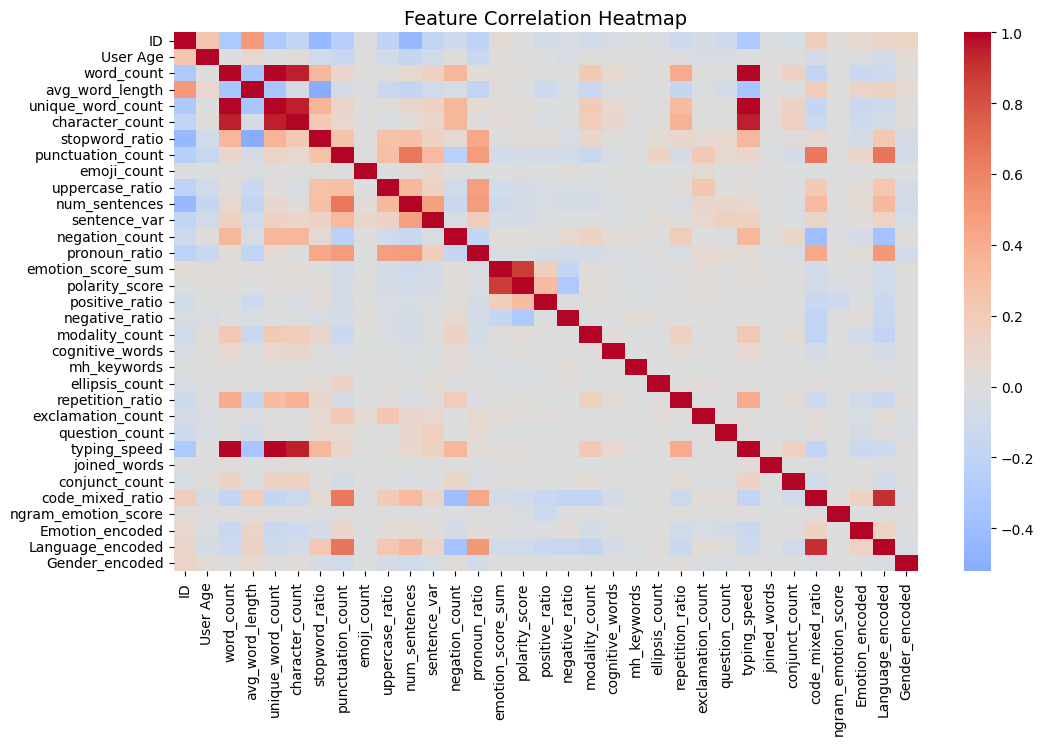

In [ ]:
# ----------------------------------------------------
# 3. Correlation Heatmap
# ----------------------------------------------------
plt.figure(figsize=(12,7))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

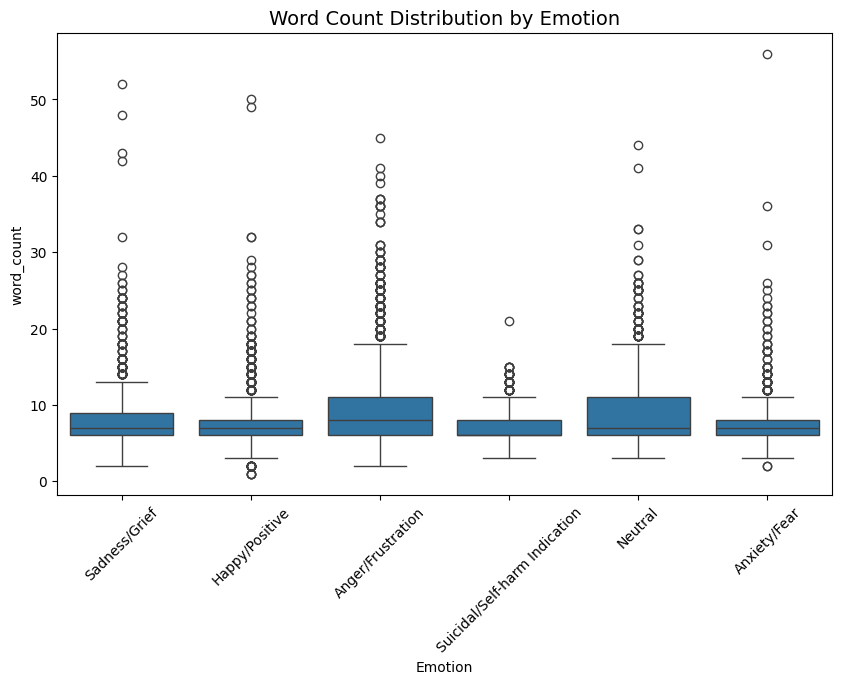

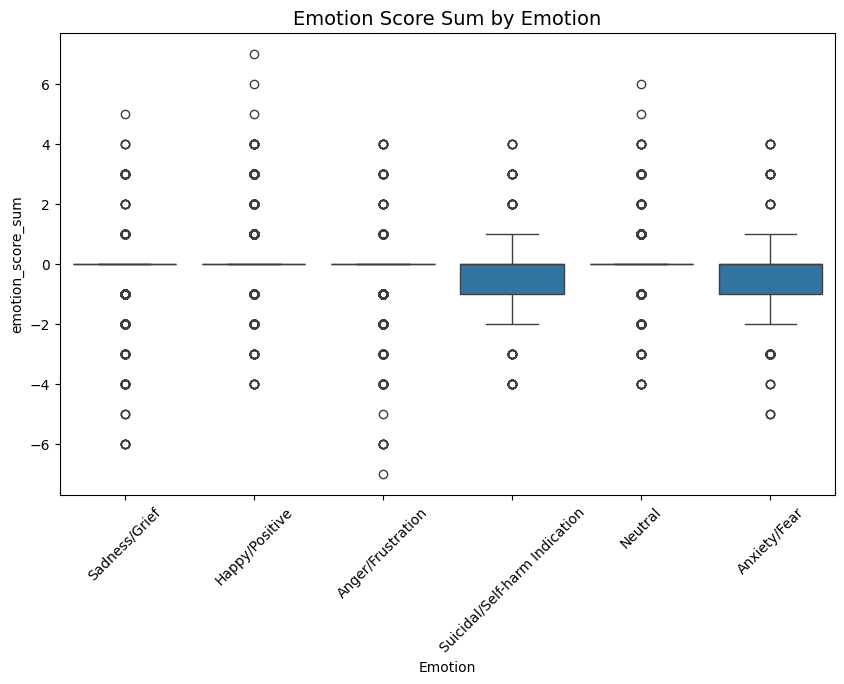

In [ ]:
# ----------------------------------------------------
# 4. Feature Distribution by Emotion
# ----------------------------------------------------
plt.figure(figsize=(10,6))
sns.boxplot(x='Emotion', y='word_count', data=df)
plt.title("Word Count Distribution by Emotion", fontsize=14)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='Emotion', y='emotion_score_sum', data=df)
plt.title("Emotion Score Sum by Emotion", fontsize=14)
plt.xticks(rotation=45)
plt.show()


## Visualization

/tmp/ipython-input-3296051808.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Emotion", palette="viridis")


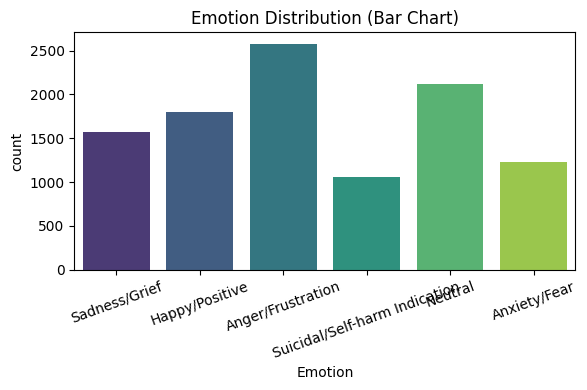

In [ ]:
# 1. Emotion Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Emotion", palette="viridis")
plt.title("Emotion Distribution (Bar Chart)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

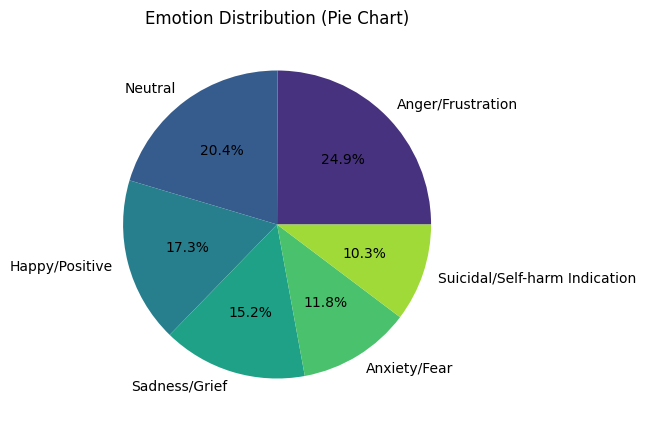

In [ ]:
plt.figure(figsize=(5,5))
df['Emotion'].value_counts().plot.pie(
    autopct='%1.1f%%',
    colors=sns.color_palette("viridis")
)
plt.title("Emotion Distribution (Pie Chart)")
plt.ylabel("")
plt.show()

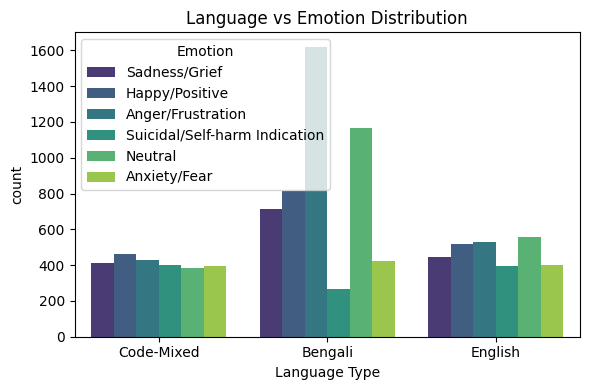

In [ ]:
#Soumili
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Language Type", hue="Emotion", palette="viridis")
plt.title("Language vs Emotion Distribution")
plt.tight_layout()
plt.show()



/tmp/ipython-input-1718607214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Emotion", y="word_count", palette="viridis")


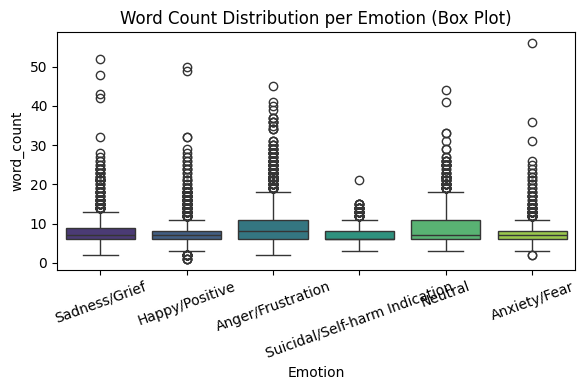

In [ ]:

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Emotion", y="word_count", palette="viridis")
plt.title("Word Count Distribution per Emotion (Box Plot)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1527986822.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Emotion", y="word_count", palette="viridis")


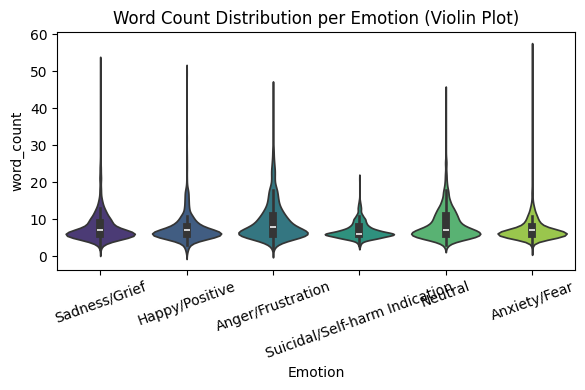

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(data=df, x="Emotion", y="word_count", palette="viridis")
plt.title("Word Count Distribution per Emotion (Violin Plot)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

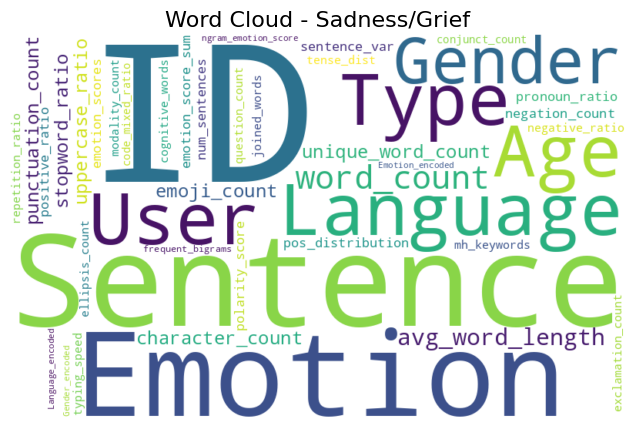

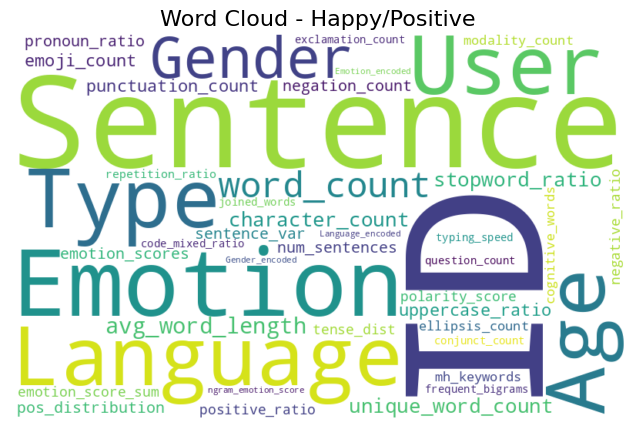

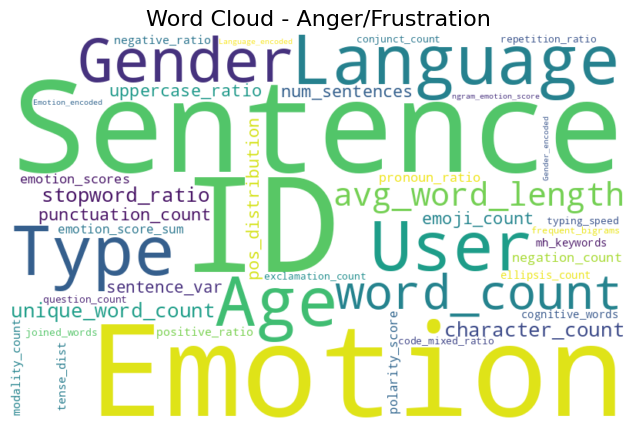

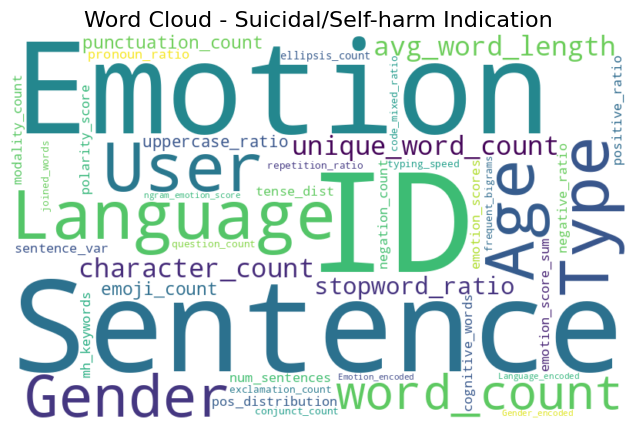

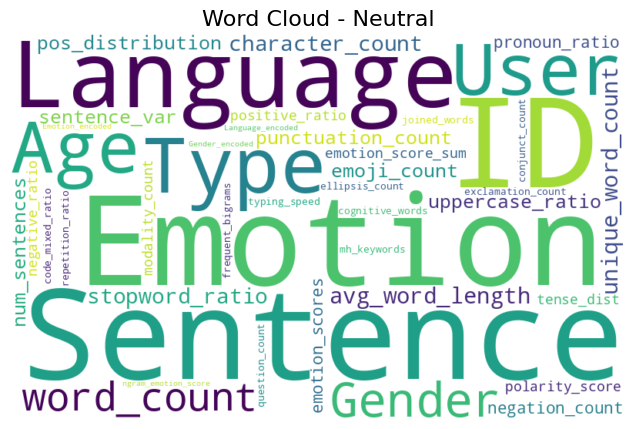

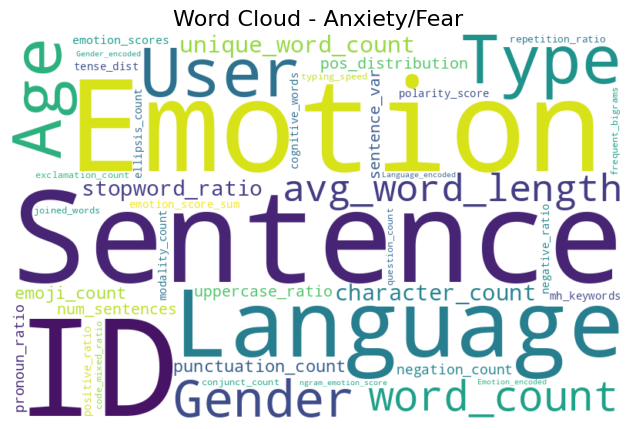

In [ ]:

# Example: generate word clouds per emotion
emotions = df['Emotion'].unique()

for emo in emotions:
    text = " ".join(df[df['Emotion'] == emo])

    # Create classic style word cloud
    wc = WordCloud(
        width=800, height=500,
        background_color="white",   # clean white background
        colormap="viridis",         # nice gradient colors
        max_words=100,              # top N words
        collocations=False,         # avoid joining common pairs
        font_path=None              # set path if Bengali needed
    ).generate(text)

    # Show word cloud
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {emo}", fontsize=16)
    plt.show()


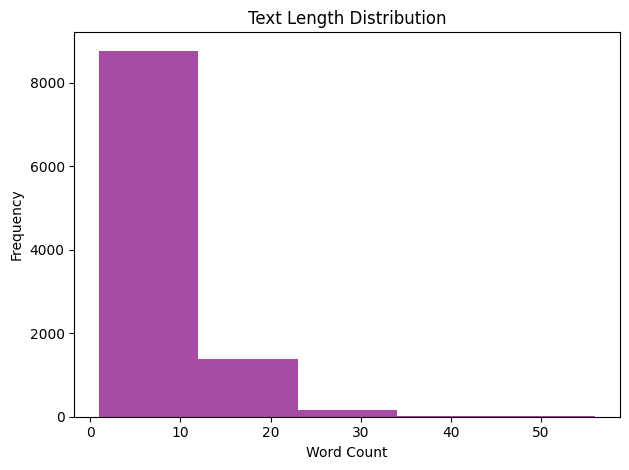

In [ ]:
plt.hist(df['word_count'], bins=5, color="purple", alpha=0.7)
plt.title("Text Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

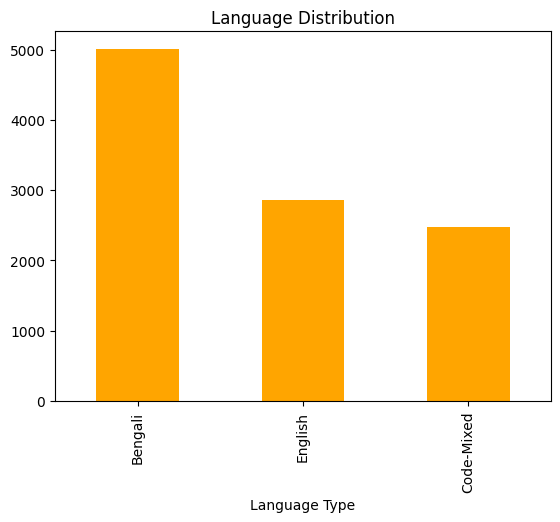

In [ ]:
df['Language Type'].value_counts().plot(kind="bar", color="orange")
plt.title("Language Distribution")
plt.show()


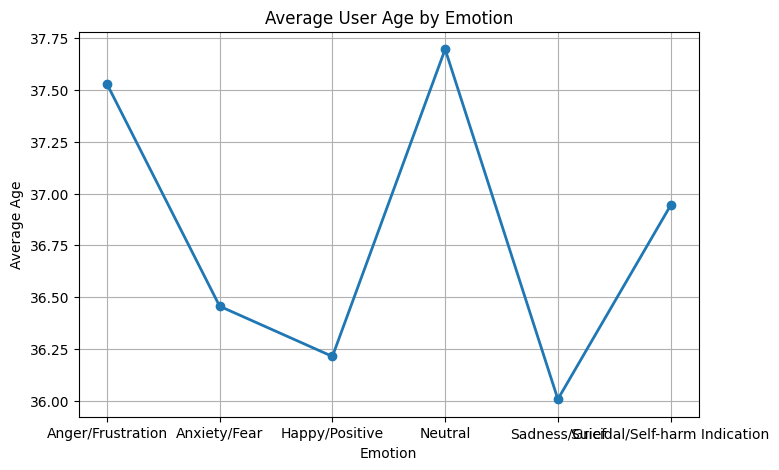

In [ ]:
avg_age = df.groupby('Emotion')['User Age'].mean()

plt.figure(figsize=(8,5))
plt.plot(avg_age.index, avg_age.values, marker='o', linestyle='-', linewidth=2)
plt.title('Average User Age by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Age')
plt.grid(True)
plt.show()

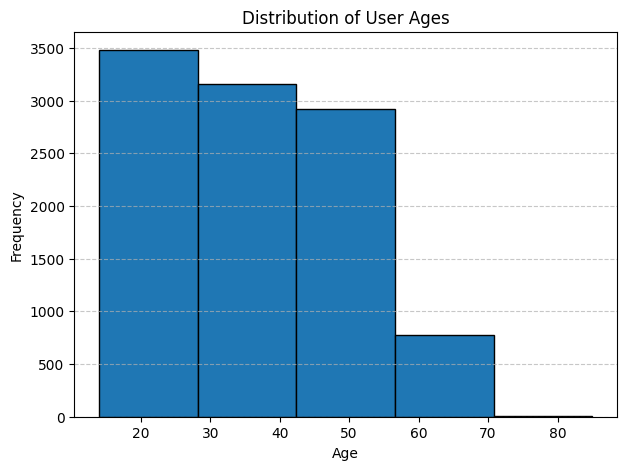

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(df['User Age'], bins=5, edgecolor='black')
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Hybrid Training and Testing

In [ ]:

# -------------------------------
# 1. Encode Categorical Columns
# -------------------------------
le_lang = LabelEncoder()
le_gender = LabelEncoder()

df['Lang_Code'] = le_lang.fit_transform(df['Language Type'])
df['Gender_Code'] = le_gender.fit_transform(df['Gender'])

# -------------------------------
# 2.Define Features (X) and Target (y)
# -------------------------------
X_text = df['Sentence']            # text data
X_meta = df[['User Age', 'Lang_Code', 'Gender_Code']]  # numeric + encoded features
y = df['Emotion']

# -------------------------------
# 3. Train-Test Split
# -------------------------------
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    X_text, X_meta, y, test_size=0.3, random_state=42, stratify=y
)

# -------------------------------
# 4. TF-IDF Vectorization for Text
# -------------------------------
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)

# -------------------------------
# 5. Scale Numeric Features
# -------------------------------
scaler = StandardScaler()
X_train_meta_scaled = scaler.fit_transform(X_train_meta)
X_test_meta_scaled = scaler.transform(X_test_meta)

# Combine TF-IDF and metadata
X_train_combined = hstack([X_train_tfidf, X_train_meta_scaled])
X_test_combined = hstack([X_test_tfidf, X_test_meta_scaled])

# -------------------------------
# 6. Model Training
# -------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train_combined, y_train)

# -------------------------------
# 7. Model Testing
# -------------------------------
y_pred = model.predict(X_test_combined)

# -------------------------------
# 8. Evaluation
# -------------------------------
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 43.89 %

📊 Classification Report:
                                precision    recall  f1-score   support

            Anger/Frustration       0.46      0.56      0.51       774
                 Anxiety/Fear       0.40      0.34      0.36       367
               Happy/Positive       0.46      0.49      0.47       538
                      Neutral       0.38      0.40      0.39       634
                Sadness/Grief       0.47      0.34      0.40       471
Suicidal/Self-harm Indication       0.49      0.39      0.43       319

                     accuracy                           0.44      3103
                    macro avg       0.44      0.42      0.43      3103
                 weighted avg       0.44      0.44      0.44      3103



## Cross Validation


In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for train_idx, test_idx in cv.split(X_text, y):
    X_train_cv_text, X_test_cv_text = X_text.iloc[train_idx], X_text.iloc[test_idx]
    X_train_cv_meta, X_test_cv_meta = X_meta.iloc[train_idx], X_meta.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]

    # TF-IDF
    X_train_cv_tfidf = vectorizer.fit_transform(X_train_cv_text)
    X_test_cv_tfidf = vectorizer.transform(X_test_cv_text)

    # Scale meta features
    X_train_cv_meta_scaled = scaler.fit_transform(X_train_cv_meta)
    X_test_cv_meta_scaled = scaler.transform(X_test_cv_meta)

    # Combine
    X_train_cv_combined = hstack([X_train_cv_tfidf, X_train_cv_meta_scaled])
    X_test_cv_combined = hstack([X_test_cv_tfidf, X_test_cv_meta_scaled])

    # Train
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_cv_combined, y_train_cv)

    # Accuracy
    acc = model.score(X_test_cv_combined, y_test_cv)
    cv_accuracies.append(acc)

print("5-Fold CV Mean Accuracy:", round(np.mean(cv_accuracies)*100, 2), "%")
print("5-Fold CV Std Dev:", round(np.std(cv_accuracies)*100, 2), "%")


5-Fold CV Mean Accuracy: 45.57 %
5-Fold CV Std Dev: 1.17 %


## ML models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
    "Multinomial Naive Bayes": MultinomialNB()  # NB uses text only
}


In [ ]:
for name, model_instance in models.items():
    print(f"\n=== Training {name} ===")

    # MultinomialNB cannot handle scaled numeric features, so we use TF-IDF text only
    if name == "Multinomial Naive Bayes":
        model_instance.fit(X_train_tfidf, y_train)
        y_pred = model_instance.predict(X_test_tfidf)
    else:
        model_instance.fit(X_train_combined, y_train)
        y_pred = model_instance.predict(X_test_combined)

    # Accuracy and Classification Report
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


=== Training Logistic Regression ===
Accuracy: 43.89%

Classification Report:
                                precision    recall  f1-score   support

            Anger/Frustration       0.46      0.56      0.51       774
                 Anxiety/Fear       0.40      0.34      0.36       367
               Happy/Positive       0.46      0.49      0.47       538
                      Neutral       0.38      0.40      0.39       634
                Sadness/Grief       0.47      0.34      0.40       471
Suicidal/Self-harm Indication       0.49      0.39      0.43       319

                     accuracy                           0.44      3103
                    macro avg       0.44      0.42      0.43      3103
                 weighted avg       0.44      0.44      0.44      3103


=== Training SVM ===
Accuracy: 44.34%

Classification Report:
                                precision    recall  f1-score   support

            Anger/Frustration       0.45      0.60      0.51       774


## ROC-AUC CURVE

ROC-AUC Score (Multinomial Naive Bayes): 0.762


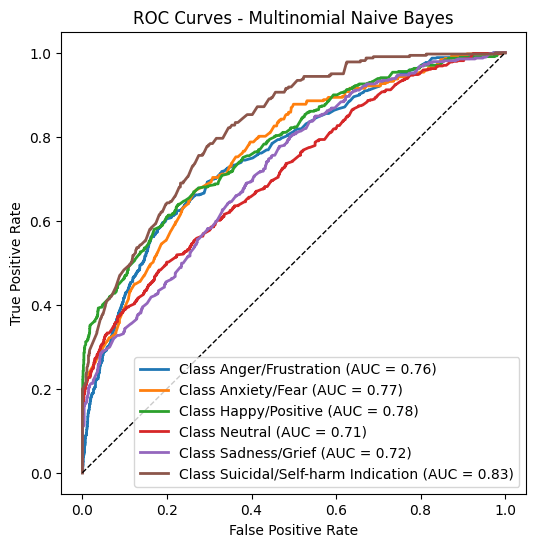

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score

# -----------------------------
# ROC-AUC Computation (Multi-class supported)
# -----------------------------
try:
    # Get predicted probabilities for the test set
    # For Naive Bayes, we already used TF-IDF; for others, combined features
    if name == "Multinomial Naive Bayes":
        y_pred_prob = model_instance.predict_proba(X_test_tfidf)
    else:
        y_pred_prob = model_instance.predict_proba(X_test_combined)

    # Binarize labels for multi-class ROC-AUC
    classes = sorted(list(set(y_test)))
    y_test_bin = label_binarize(y_test, classes=classes)

    # Compute ROC-AUC using One-vs-Rest approach
    roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class='ovr')
    print(f"ROC-AUC Score ({name}): {roc_auc:.3f}")

    # Optional: Plot ROC for each class
    plt.figure(figsize=(6, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, lw=2, label=f'Class {classes[i]} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {name}')
    plt.legend(loc='lower right')
    plt.show()

except Exception as e:
    print(f"ROC-AUC not available for {name}: {e}")


## Accuracy comparison


=== Training Logistic Regression ===

=== Training SVM ===

=== Training Random Forest ===

=== Training K-Nearest Neighbors ===

=== Training Multinomial Naive Bayes ===


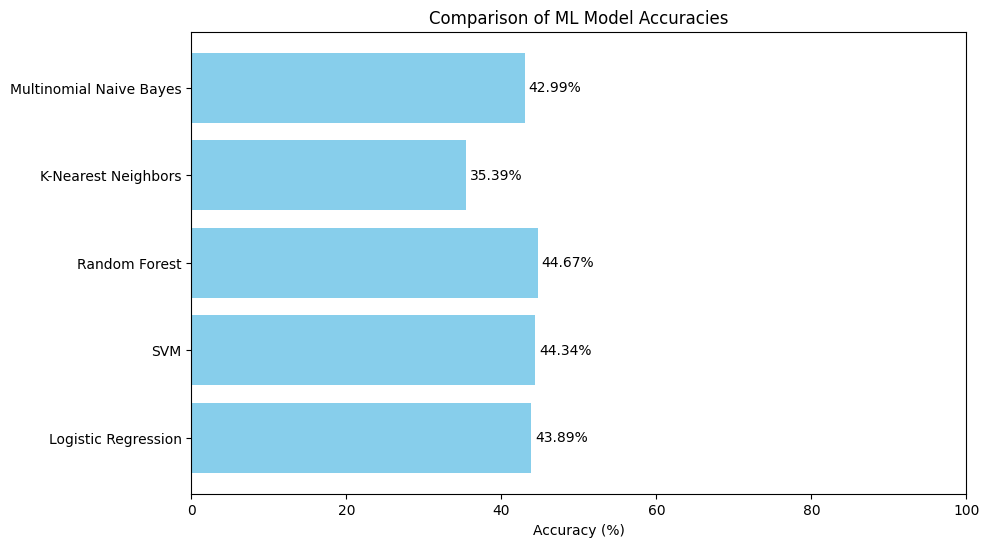

In [ ]:
model_names = []
accuracies = []

# -------------------------------
# Train and Evaluate Models
# -------------------------------
for name, model_instance in models.items():
    print(f"\n=== Training {name} ===")

    if name == "Multinomial Naive Bayes":
        model_instance.fit(X_train_tfidf, y_train)
        y_pred = model_instance.predict(X_test_tfidf)
    else:
        model_instance.fit(X_train_combined, y_train)
        y_pred = model_instance.predict(X_test_combined)

    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    model_names.append(name)
    accuracies.append(acc)

    # print(f"Accuracy: {acc}%")
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -------------------------------
# Visualization: Horizontal Bar Graph
# -------------------------------
plt.figure(figsize=(10,6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel("Accuracy (%)")
plt.title("Comparison of ML Model Accuracies")
plt.xlim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(v + 0.5, i, str(v) + "%", va='center')
plt.show()

# -------------------------------
# Identify the Best Model
# -------------------------------
max_acc_index = accuracies.index(max(accuracies))
best_model_name = model_names[max_acc_index]
best_model_accuracy = accuracies[max_acc_index]



In [ ]:
print(f"\n✅ Most Accurate Model: {best_model_name} with Accuracy: {best_model_accuracy}%")


✅ Most Accurate Model: Random Forest with Accuracy: 44.67%


## Transformer

In [ ]:

# --- Translator: Bengali → English ---
translator = Translator()

def translate_bn_to_en(text: str) -> str:
    translated = translator.translate(text, src='bn', dest='en')
    return translated.text

# --- Emotion classifier (English) ---
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    device=-1,
    truncation=True
)

# --- Normalize Bengali slang/colloquial words before translation ---
slang_map = {
    "furti": "happy",
    "khushi": "joy",
    "bhalo": "good",
    "mon bhalo": "happy",
    "dukho": "sad",
    "kharap": "bad",
    "hebi valo": "happy"
}

def normalize_bengali_text(text: str) -> str:
    t_low = text.lower()
    for bn_word, en_word in slang_map.items():
        t_low = t_low.replace(bn_word, en_word)
    return t_low

# --- Keywords ---
suicidal_keywords = [
    "more jete iccha", "more jete chai", "more jabo", "marte chai",
    "amar jibon sesh", "amar sesh", "jibon sesh korte chai",
    "atmahatya", "aatmahatya", "suicide", "self harm", "self-harm",
    "nijeke marbo", "nijeke sesh korbo", "banchte iccha nei", "bachte chaina",
    "ar parchi na", "amar shesh", "morle bhalo hoto", "phasi nebo",
    "bish khabo", "jump korbo", "train e kude debo","i don't want to live", "i dont want to live",
    "i can't go on", "i cant go on",
    "life is not worth", "end my life",
    "kill myself", "die", "i want to die",
    "living anymore", "no reason to live"
]

threat_keywords = [
    "ami toke mere felbo", "mere felbo", "ghushie debo", "toke katbo",
    "toke goli korbo", "toke dhongsho korbo", "tor jibon sesh", "marbo toke",
    "rokto khun", "pagol kore debo", "toke noshto kore debo"
]

# --- Suggestions by emotion ---
suggestion_dict = {
    "joy": "🌟 Stay positive and continue what makes you happy!",
    "sadness": "💙 It’s okay to feel low sometimes, but things will improve.",
    "anger": "😡 Try calming activities like deep breathing or a walk.",
    "fear": "✅ Try calming activities like deep breathing or grounding yourself.",
    "surprise": "😲 Unexpected things happen — take a moment to process calmly.",
    "disgust": "🤢 Try distancing yourself from what’s making you uncomfortable.",
    "neutral": "😌 Stay mindful and balanced.",
}

# --- Extended emotion cause keywords ---
cause_keywords = {
    "job": ["kaj", "job", "career", "boss", "promotion", "salary", "interview", "office", "co-worker", "assignment"],
    "family": ["baba", "ma", "poribar", "bhai", "bon", "pita", "mata", "chhele", "meye", "family", "parents", "home"],
    "love/relationship": ["prem", "love", "valobasha", "chele", "mey", "boyfriend", "girlfriend", "breakup", "dating", "relationship"],
    "study/education": ["porashona", "exam", "study", "class", "assignment", "project", "results", "test", "university", "school", "college"],
    "health": ["shorir", "bimar", "doctor", "hospital", "illness", "disease", "pain", "treatment", "sick"],
    "financial": ["taka", "loan", "bank", "money", "expense", "budget", "financial", "bikri", "shopping"],
    "friendship/social": ["bondhu", "friend", "friends", "party", "social", "meet", "hangout", "conflict", "betrayal"],
    "self-esteem/personal": ["niye asha", "confidence", "motivation", "success", "failure", "disappointed", "insecure", "stress"],
    "environmental/stress": ["traffic", "pollution", "noise", "workload", "pressure", "deadline", "stressful", "overwhelmed"],
    "romantic loss/grief": ["bere hoye geche", "bere giyeche", "lost love", "heartbroken", "separation", "mourning"],
}

# --- Session memory ---
session_memory = []

# --- Forensic Feature Extraction ---
def extract_forensic_features(text: str) -> dict:
    words = re.findall(r"\w+", text)
    word_count = len(words)
    avg_word_length = sum(len(w) for w in words) / word_count if word_count else 0
    repetition_count = sum(text.lower().split().count(w) > 1 for w in set(text.lower().split()))
    negation_count = len(re.findall(r"\b(na|nai|no|not|never|don\'t|can't|won't)\b", text.lower()))
    passive_voice = len(re.findall(r"\b(be|was|were|been|being|is|are|am)\s+\w+ed\b", text.lower()))
    exclamations = text.count("!")
    ellipsis = text.count("...")
    return {
        "word_count": word_count,
        "avg_word_length": avg_word_length,
        "repetition_count": repetition_count,
        "negation_count": negation_count,
        "passive_voice": passive_voice,
        "exclamations": exclamations,
        "ellipsis": ellipsis
    }

# --- Smart Bengali sentence splitter ---
def split_bengali_sentences(text: str):
    # Split at ., ? ! or conjunctions like কিন্তু, এবং, অথবা
    parts = re.split(r'(?<=।)|(?<=\?)|(?<=!)|(?<=,)|\s+কিন্তু\s+|\s+এবং\s+|\s+অথবা\s+', text)
    return [p.strip() for p in parts if p.strip()]

# --- Analyze function ---
def analyze_text_multi_emotion(text: str):
    clauses = split_bengali_sentences(text)
    results = []
    session_memory.clear()  # clear once at the start

    for clause in clauses:
        # Normalize slang
        text_norm = normalize_bengali_text(clause)

        # Translate safely
        try:
            translated = translate_bn_to_en(text_norm)
            if not translated:
                translated = text_norm
        except:
            translated = text_norm

        # Emotion detection (top-3)
        emo_res = emotion_classifier(translated, top_k=3)
        if not emo_res:
            continue  # skip if classifier fails

        top = emo_res[0]
        label = top["label"].lower()
        score = float(top["score"])

        # Intensity
        if score >= 0.85:
            intensity = "high"
            intensity_num = 3
        elif score >= 0.65:
            intensity = "medium"
            intensity_num = 2
        else:
            intensity = "low"
            intensity_num = 1

        # Suicide/Threat detection
        t_low = clause.lower()
        if any(k in t_low for k in suicidal_keywords):
            stage2 = "suicidal"
            suggestion = "⚠️ Please reach out to a trusted friend or professional immediately."
            risk_score = 10
        elif any(k in t_low for k in threat_keywords):
            stage2 = "threat/anger"
            suggestion = "⚠️ This text contains violent intent. Stay safe and alert authorities if needed."
            risk_score = 8
        else:
            stage2 = "not suicidal"
            suggestion = suggestion_dict.get(label, "💡 Take care of yourself, and stay mindful.")
            risk_score = intensity_num * 2 if label in ["sadness", "anger", "fear"] else intensity_num

        # Multi-cause detection
        causes_detected = [cause for cause, keywords in cause_keywords.items() if any(k in t_low for k in keywords)]
        if not causes_detected:
            causes_detected = ["unknown"]

        # Forensics
        forensics = extract_forensic_features(clause)

        # Store session
        session_memory.append({
            "sentence": clause,
            "label": label,
            "score": round(score, 3),
            "Intensity": intensity,
            "stage2": stage2,
            "risk_score": risk_score,
            "causes": causes_detected,
            "suggestion": suggestion,
            "Forensics": forensics,
            "Top_3_Emotions": emo_res
        })

        # Prepare output
        results.append({
            "Sentence": clause,
            "Emotion": label,
            "Accuracy": f"{score*100:.2f}%",
            "Suggestion": suggestion
        })

    return results

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [ ]:

import re
import json
from transformers import pipeline

# --- Zero-shot classifier using IndicBERT multilingual model ---
emotion_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=-1  # CPU
)

# --- Define emotion labels ---
emotion_labels = ["joy", "sadness", "anger", "fear", "surprise", "neutral"]

# --- Normalize Bengali slang ---
slang_map = {
    "furti": "happy",
    "khushi": "joy",
    "bhalo": "good",
    "mon bhalo": "happy",
    "dukho": "sad",
    "kharap": "bad"
}

def normalize_bengali_text(text: str) -> str:
    t_low = text.lower()
    for bn_word, en_word in slang_map.items():
        t_low = t_low.replace(bn_word, en_word)
    return t_low

# --- Keywords for risk assessment ---
suicidal_keywords = ["marte chai", "amar jibon sesh", "suicide", "atmahatya", "kill myself", "i want to die"]
threat_keywords = ["toke goli korbo", "tor jibon sesh", "pagol kore debo"]

# --- Suggestions by emotion ---
suggestion_dict = {
    "joy": "🌟 Stay positive and continue what makes you happy!",
    "sadness": "💙 It’s okay to feel low sometimes, but things will improve.",
    "anger": "😡 Try calming activities like deep breathing or a walk.",
    "fear": "✅ Try calming activities like deep breathing or grounding yourself.",
    "surprise": "😲 Unexpected things happen — take a moment to process calmly.",
    "neutral": "😌 Stay mindful and balanced.",
}

# --- Cause keywords ---
cause_keywords = {
    "job": ["kaj", "job", "career", "boss", "promotion", "salary", "interview", "office"],
    "family": ["baba", "ma", "poribar", "bhai", "bon", "family", "parents"],
    "love/relationship": ["prem", "love", "chele", "mey", "boyfriend", "girlfriend", "breakup", "relationship"],
    "study/education": ["porashona", "exam", "study", "class", "assignment", "project", "results", "school", "college"],
    "health": ["shorir", "bimar", "doctor", "hospital", "illness", "pain"],
    "financial": ["taka", "loan", "bank", "money", "expense", "budget"],
    "friendship/social": ["bondhu", "friend", "friends", "party", "social", "meet"],
    "self-esteem/personal": ["confidence", "motivation", "success", "failure", "stress"],
    "environmental/stress": ["traffic", "pollution", "noise", "pressure", "deadline", "overwhelmed"],
    "romantic loss/grief": ["bere hoye geche", "lost love", "heartbroken", "separation", "mourning"],
}

# --- Session memory ---
session_memory = []

# --- Forensic feature extraction ---
def extract_forensic_features(text: str) -> dict:
    words = re.findall(r"\w+", text)
    word_count = len(words)
    avg_word_length = sum(len(w) for w in words) / word_count if word_count else 0
    repetition_count = sum(text.lower().split().count(w) > 1 for w in set(text.lower().split()))
    negation_count = len(re.findall(r"\b(na|nai|no|not|never|don\'t|can't|won't)\b", text.lower()))
    passive_voice = len(re.findall(r"\b(be|was|were|been|being|is|are|am)\s+\w+ed\b", text.lower()))
    exclamations = text.count("!")
    ellipsis = text.count("...")
    return {
        "word_count": word_count,
        "avg_word_length": avg_word_length,
        "repetition_count": repetition_count,
        "negation_count": negation_count,
        "passive_voice": passive_voice,
        "exclamations": exclamations,
        "ellipsis": ellipsis
    }

# --- Bengali clause splitter (fixed) ---
def split_bengali_clauses(text: str):
    clauses = re.split(r'\s*(?:,|কিন্তু|তবে|এবং|আর|বা)\s*', text)
    return [c.strip() for c in clauses if c.strip()]

def analyze_text_advanced(text: str):
    clauses = split_bengali_clauses(text)
    results = []
    session_memory.clear()  # clear memory at the start

    for clause in clauses:
        if not clause.strip():
            continue  # skip empty clauses

        text_norm = normalize_bengali_text(clause)

        # ✅ Zero-shot classification safely
        try:
            res = emotion_classifier(
                sequences=text_norm,
                labels=emotion_labels,
                hypothesis_template="This text expresses {}."
            )
        except Exception as e:
            # fallback if classifier fails
            res = {"labels": ["neutral"], "scores": [1.0]}

        label = res['labels'][0]
        score = res['scores'][0]

        # Intensity
        if score >= 0.85:
            intensity = "high"
            intensity_num = 3
        elif score >= 0.65:
            intensity = "medium"
            intensity_num = 2
        else:
            intensity = "low"
            intensity_num = 1

        # Risk assessment
        t_low = clause.lower()
        if any(k in t_low for k in suicidal_keywords):
            stage2 = "suicidal"
            suggestion = "⚠️ Please reach out to a trusted friend or professional immediately."
            risk_score = 10
        elif any(k in t_low for k in threat_keywords):
            stage2 = "threat/anger"
            suggestion = "⚠️ This text contains violent intent. Stay safe and alert authorities if needed."
            risk_score = 8
        else:
            stage2 = "not suicidal"
            suggestion = suggestion_dict.get(label, "💡 Take care of yourself.")
            risk_score = intensity_num * 2 if label in ["sadness", "anger", "fear"] else intensity_num

        # Cause detection
        causes_detected = [cause for cause, keywords in cause_keywords.items() if any(k in t_low for k in keywords)]
        if not causes_detected:
            causes_detected = ["unknown"]

        # Forensics
        forensics = extract_forensic_features(clause)

        # Store session
        session_memory.append({
            "sentence": clause,
            "label": label,
            "score": round(score, 3),
            "Intensity": intensity,
            "intensity_num": intensity_num,
            "stage2": stage2,
            "risk_score": risk_score,
            "causes": causes_detected,
            "suggestion": suggestion,
            "Forensics": forensics
        })

        # Prepare output
        top_3 = [{"Emotion": res['labels'][i], "Confidence": f"{res['scores'][i]*100:.2f}%"} for i in range(min(3, len(res['labels'])))]
        results.append({
            "Sentence": clause,
            "Emotion": label,
            "Accuracy": f"{score*100:.2f}%",
            "Suggestion": suggestion
        })

    return results


Device set to use cpu


In [ ]:
import re
import json
from transformers import pipeline
from googletrans import Translator

# --- Translator: Bengali → English ---
translator = Translator()

def translate_bn_to_en(text: str) -> str:
    translated = translator.translate(text, src='bn', dest='en')
    return translated.text

# --- Emotion classifier (XLNet-based) ---
from transformers import pipeline

# XLNet emotion model
emotion_classifier = pipeline(
    "text-classification",
    model="sherelyn912/emotional-xlnet",
    return_all_scores=True
)



# --- Normalize Bengali slang/colloquial words before translation ---
slang_map = {
    "furti": "happy",
    "khushi": "joy",
    "bhalo": "good",
    "mon bhalo": "happy",
    "dukho": "sad",
    "mon kemon":"sad",
    "kharap": "bad",
    "hebi valo": "happy"
}

def normalize_bengali_text(text: str) -> str:
    t_low = text.lower()
    for bn_word, en_word in slang_map.items():
        t_low = t_low.replace(bn_word, en_word)
    return t_low

# --- Keywords for suicide/threat ---
suicidal_keywords = [
    "more jete iccha", "more jete chai", "more jabo", "marte chai",
    "amar jibon sesh", "amar sesh", "jibon sesh korte chai",
    "atmahatya", "aatmahatya", "suicide", "self harm", "self-harm",
    "nijeke marbo", "nijeke sesh korbo", "banchte iccha nei", "bachte chaina",
    "ar parchi na", "amar shesh", "morle bhalo hoto", "phasi nebo",
    "bish khabo", "jump korbo", "train e kude debo","i don't want to live", "i dont want to live",
    "i can't go on", "i cant go on",
    "life is not worth", "end my life",
    "kill myself", "die", "i want to die",
    "living anymore", "no reason to live"
]

threat_keywords = [
    "ami toke mere felbo", "mere felbo", "ghushie debo", "toke katbo",
    "toke goli korbo", "toke dhongsho korbo", "tor jibon sesh", "marbo toke",
    "rokto khun", "pagol kore debo", "toke noshto kore debo"
]

# --- Suggestions by emotion ---
suggestion_dict = {
    "joy": "🌟 Stay positive and continue what makes you happy!",
    "sadness": "💙 It’s okay to feel low sometimes, but things will improve.",
    "anger": "😡 Try calming activities like deep breathing or a walk.",
    "fear": "✅ Try calming activities like deep breathing or grounding yourself.",
    "surprise": "😲 Unexpected things happen — take a moment to process calmly.",
    "disgust": "🤢 Try distancing yourself from what’s making you uncomfortable.",
    "neutral": "😌 Stay mindful and balanced.",
}

# --- Cause keywords (same as before) ---
cause_keywords = {
    "job": ["kaj", "job", "career", "boss", "promotion", "salary", "interview", "office", "co-worker", "assignment"],
    "family": ["baba", "ma", "poribar", "bhai", "bon", "pita", "mata", "chhele", "meye", "family", "parents", "home"],
    "love/relationship": ["prem", "love", "valobasha", "chele", "mey", "boyfriend", "girlfriend", "breakup", "dating", "relationship"],
    "study/education": ["porashona", "exam", "study", "class", "assignment", "project", "results", "test", "university", "school", "college"],
    "health": ["shorir", "bimar", "doctor", "hospital", "illness", "disease", "pain", "treatment", "sick"],
    "financial": ["taka", "loan", "bank", "money", "expense", "budget", "financial", "bikri", "shopping"],
    "friendship/social": ["bondhu", "friend", "friends", "party", "social", "meet", "hangout", "conflict", "betrayal"],
    "self-esteem/personal": ["niye asha", "confidence", "motivation", "success", "failure", "disappointed", "insecure", "stress"],
    "environmental/stress": ["traffic", "pollution", "noise", "workload", "pressure", "deadline", "stressful", "overwhelmed"],
    "romantic loss/grief": ["bere hoye geche", "bere giyeche", "lost love", "heartbroken", "separation", "mourning"],
}

# --- Forensic feature extraction (same as before) ---
def extract_forensic_features(text: str) -> dict:
    words = re.findall(r"\w+", text)
    word_count = len(words)
    avg_word_length = sum(len(w) for w in words) / word_count if word_count else 0
    repetition_count = sum(text.lower().split().count(w) > 1 for w in set(text.lower().split()))
    negation_count = len(re.findall(r"\b(na|nai|no|not|never|don\'t|can't|won't)\b", text.lower()))
    passive_voice = len(re.findall(r"\b(be|was|were|been|being|is|are|am)\s+\w+ed\b", text.lower()))
    exclamations = text.count("!")
    ellipsis = text.count("...")
    return {
        "word_count": word_count,
        "avg_word_length": avg_word_length,
        "repetition_count": repetition_count,
        "negation_count": negation_count,
        "passive_voice": passive_voice,
        "exclamations": exclamations,
        "ellipsis": ellipsis
    }

# --- Bengali sentence splitter ---
def split_bengali_sentences(text: str):
    parts = re.split(r'(?<=।)|(?<=\?)|(?<=!)|(?<=,)|\s+কিন্তু\s+|\s+এবং\s+|\s+অথবা\s+', text)
    return [p.strip() for p in parts if p.strip()]

# --- Main analysis (unchanged, but now uses XLNet) ---
session_memory = []

def analyze_text_multi_emotion(text: str):
    clauses = split_bengali_sentences(text)
    results = []
    session_memory.clear()
    for clause in clauses:
        text_norm = normalize_bengali_text(clause)
        translated = translate_bn_to_en(text_norm)
        emo_res = emotion_classifier(translated)[0]
        top = max(emo_res, key=lambda x: x["score"])
        label = top["label"].lower()
        score = float(top["score"])

        # Emotion intensity
        if score >= 0.85: intensity, intensity_num = "high", 3
        elif score >= 0.65: intensity, intensity_num = "medium", 2
        else: intensity, intensity_num = "low", 1

        # Suicide/Threat check
        t_low = clause.lower()
        if any(k in t_low for k in suicidal_keywords):
            stage2 = "suicidal"
            suggestion = "⚠️ Please reach out to a trusted friend or professional immediately."
            risk_score = 10
        elif any(k in t_low for k in threat_keywords):
            stage2 = "threat/anger"
            suggestion = "⚠️ Violent intent detected. Stay safe and alert authorities if needed."
            risk_score = 8
        else:
            stage2 = "not suicidal"
            suggestion = suggestion_dict.get(label, "💡 Take care of yourself, and stay mindful.")
            risk_score = intensity_num * 2 if label in ["sadness", "anger", "fear"] else intensity_num

        # Causes
        causes_detected = []
        for cause, keywords in cause_keywords.items():
            if any(k in t_low for k in keywords):
                causes_detected.append(cause)
        if not causes_detected:
            causes_detected.append("unknown")

        forensics = extract_forensic_features(clause)

        session_memory.append({
            "sentence": clause,
            "label": label,
            "score": round(score, 3),
            "Intensity": intensity,
            "stage2": stage2,
            "risk_score": risk_score,
            "causes": causes_detected,
            "suggestion": suggestion,
            "Forensics": forensics,
            "Top_3_Emotions": emo_res
        })

        results.append({
            "Sentence": clause,
            "Emotion": label,
            "Accuracy": f"{score*100:.2f}%",
            "Suggestion": suggestion,
        })
    return results

Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



Device set to use cpu
Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu


Enter a Bengali or English sentence: আমি এই বছর ভোট দেব না।

--- Multi-Emotion (EN model) ---
Top Emotion: sadness, Probability: 90.09%

--- XNLI Zero-Shot ---
Top Emotion: neutral, Probability: 48.28%

--- XLNet ---
Top Emotion: trust, Probability: 24.94%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2438 (\N{BENGALI LETTER AA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Matplotlib currently does not support Bengali natively.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: User

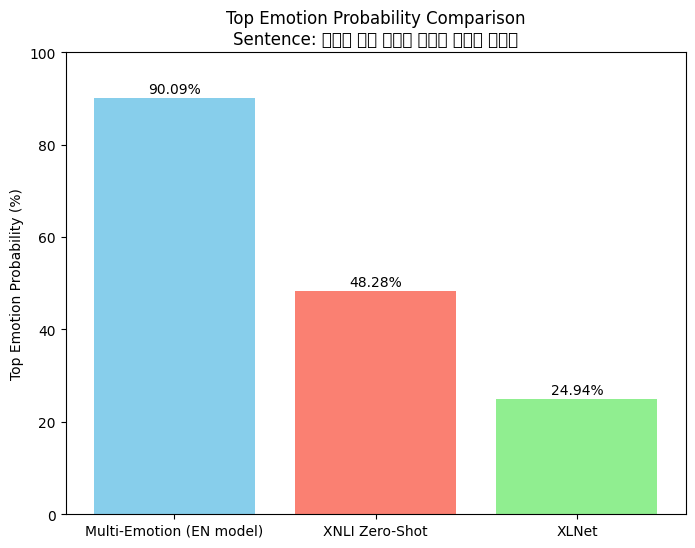

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2438 (\N{BENGALI LETTER AA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Matplotlib currently does not support Bengali natively.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: User

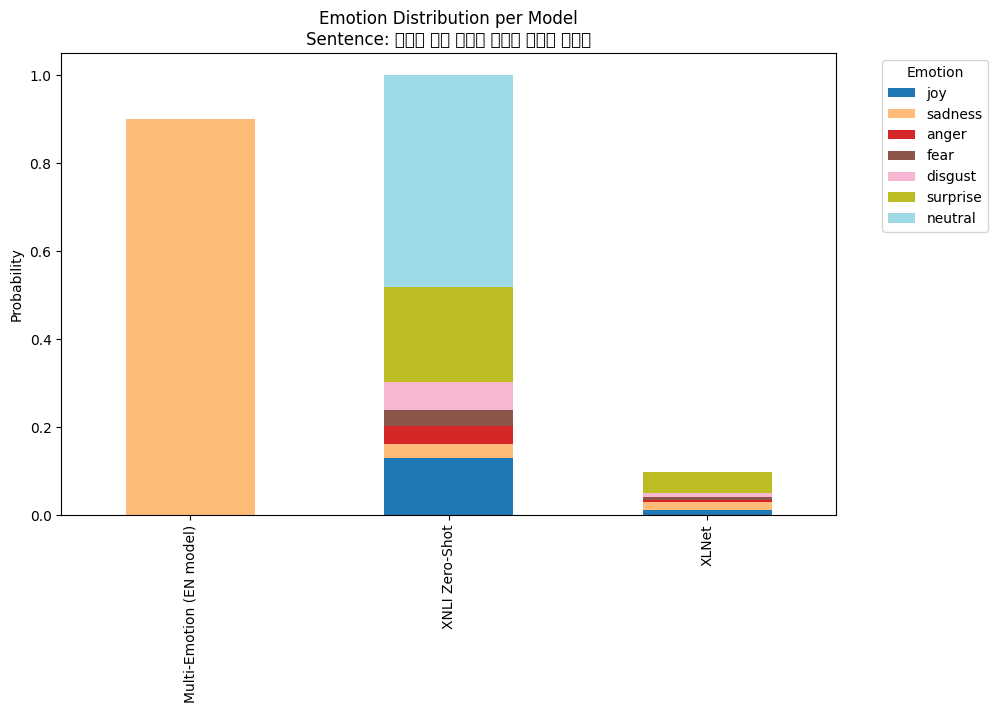

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2438 (\N{BENGALI LETTER AA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Matplotlib currently does not support Bengali natively.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2478 (\N{BENGALI LETTER MA}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2495 (\N{BENGALI VOWEL SIGN I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2447 (\N{BENGALI LETTER E}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 2439 (\N{BENGALI LETTER I}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: User

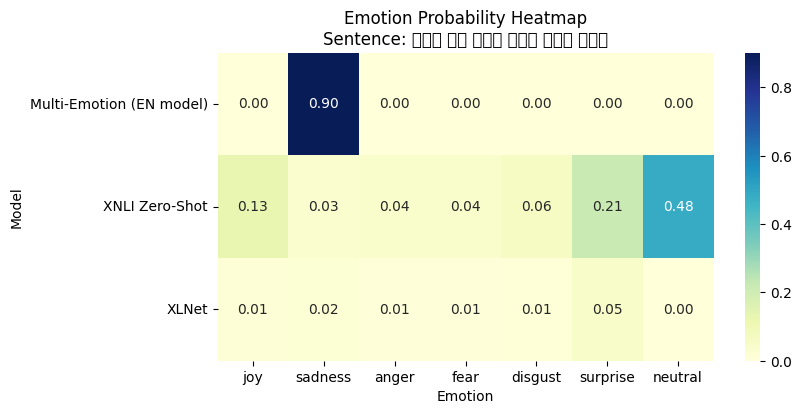

In [ ]:

#===============================
# Bengali / English Emotion Analyzer with Advanced Visualizations
# ===============================

from transformers import pipeline
from googletrans import Translator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go

# --- Translator (Bengali → English) ---
translator = Translator()
def translate_bn_to_en(text: str) -> str:
    try:
        return translator.translate(text, src='bn', dest='en').text
    except Exception:
        return text

# --- Emotion Models ---
emotion_classifier_en = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", device=-1, truncation=True)
emotion_classifier_xnli = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli", device=-1)
emotion_classifier_xlnet = pipeline("text-classification", model="sherelyn912/emotional-xlnet", return_all_scores=True, device=-1)

emotion_labels = ["joy", "sadness", "anger", "fear", "disgust", "surprise", "neutral"]
xlnet_label_map = {
    "grief": "sadness", "love": "joy", "optimism": "joy", "remorse": "sadness",
    "anger": "anger", "fear": "fear", "surprise": "surprise", "disgust": "disgust", "neutral": "neutral"
}

# --- Analyzer Functions ---
def analyze_text_multi_emotion(text: str):
    translated = translate_bn_to_en(text)
    result = emotion_classifier_en(translated)[0]
    return {
        "Model": "Multi-Emotion (EN model)",
        "Scores": {result['label']: result['score']},  # only top emotion available
        "Accuracy": result['score'],
        "Sentence": text,
        "Emotion": result['label']
    }

def analyze_text_advanced(text: str):
    res = emotion_classifier_xnli(text, emotion_labels)
    # Find the top emotion and its score
    top_emotion_index = res["scores"].index(max(res["scores"]))
    top_emotion_label = res["labels"][top_emotion_index]
    top_emotion_score = res["scores"][top_emotion_index]

    return {
        "Model": "XNLI Zero-Shot",
        "Scores": dict(zip(res["labels"], res["scores"])),
        "Accuracy": top_emotion_score,
        "Sentence": text,
        "Emotion": top_emotion_label
    }

def analyze_text_xlnet(text: str):
    translated = translate_bn_to_en(text)
    try:
        emo_res = emotion_classifier_xlnet(translated)[0]
        score_dict = {xlnet_label_map.get(x["label"].lower(), x["label"].lower()): x["score"] for x in emo_res}
        # Find the top emotion and its score from the mapped scores
        top_emotion_label = max(score_dict, key=score_dict.get)
        top_emotion_score = score_dict[top_emotion_label]

        return {
            "Model": "XLNet",
            "Scores": score_dict,
            "Accuracy": top_emotion_score,
            "Sentence": text,
            "Emotion": top_emotion_label
        }
    except Exception:
        return {
            "Model": "XLNet",
            "Scores": {label: 0 for label in emotion_labels},
            "Accuracy": 0,
            "Sentence": text,
            "Emotion": "unknown"
        }


# --- Main execution outside the if block ---
user_text = input("Enter a Bengali or English sentence: ")

# Get results from all models
res_multi = analyze_text_multi_emotion(user_text)
res_adv = analyze_text_advanced(user_text)
res_xlnet = analyze_text_xlnet(user_text)

results = [res_multi, res_adv, res_xlnet]

# Print results
for res in results:
    top_emotion = max(res["Scores"], key=res["Scores"].get)
    print(f"\n--- {res['Model']} ---")
    print(f"Top Emotion: {top_emotion}, Probability: {res['Scores'][top_emotion]*100:.2f}%")
summary_dict = {}

for res in results:
    top_emotion = max(res["Scores"], key=res["Scores"].get)
    accuracy = res["Scores"][top_emotion]  # top emotion probability
    summary_dict[res["Model"]] = {
        "Top Emotion": top_emotion,
        "Accuracy": accuracy
    }

# # Print the dictionary
# print("\nSummary Dictionary:")
# for model, info in summary_dict.items():
#     print(f"{model}: Top Emotion = {info['Top Emotion']}, Accuracy = {info['Accuracy']*100:.2f}%")
# --- 1. Accuracy Bar Chart ---
labels = [r["Model"] for r in results]
accuracies = [r["Accuracy"]*100 for r in results]
plt.figure(figsize=(8,6))
bars = plt.bar(labels, accuracies, color=["skyblue", "salmon", "lightgreen"])
plt.ylim(0,100)
plt.ylabel("Top Emotion Probability (%)")
plt.title(f"Top Emotion Probability Comparison\nSentence: {user_text}")
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1, f"{acc:.2f}%", ha='center')
plt.show()

# --- 2. Stacked Bar Chart ---
df_stack = pd.DataFrame({r["Model"]: [r["Scores"].get(e,0) for e in emotion_labels] for r in results}, index=emotion_labels)
df_stack = df_stack.T
df_stack.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.ylabel("Probability")
plt.title(f"Emotion Distribution per Model\nSentence: {user_text}")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# --- 3. Heatmap ---
plt.figure(figsize=(8,4))
sns.heatmap(df_stack, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title(f"Emotion Probability Heatmap\nSentence: {user_text}")
plt.ylabel("Model")
plt.xlabel("Emotion")
plt.show()

# --- 4. Interactive Radar Chart (Plotly) ---
fig = go.Figure()
for res in results:
    values = [res["Scores"].get(e,0) for e in emotion_labels]
    values += values[:1]  # close loop
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=emotion_labels + [emotion_labels[0]],
        fill='toself',
        name=res["Model"]
    ))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0,1])),
    title=f"Emotion Probability Radar Chart\nSentence: {user_text}",
    showlegend=True
)
fig.show()

## Hybrid aproach(Random forest + multimodel+ xnli zero shot)


In [ ]:
def ensemble_predict(text, ml_model, ml_features, multi_model_fn, xnli_model_fn, emotion_labels):
    # --- ML Model Probabilities ---
    ml_pred_probs = ml_model.predict_proba(ml_features.getrow(0))[0]
    ml_probs = {label: ml_pred_probs[i] for i, label in enumerate(ml_model.classes_)}
    # Ensure all emotion_labels are included
    for label in emotion_labels:
        if label not in ml_probs:
            ml_probs[label] = 0.0

    # --- Transformer Model Probabilities ---
    multi_res = multi_model_fn(text)
    xnli_res = xnli_model_fn(text)
    multi_probs = multi_res["Scores"]
    xnli_probs = xnli_res["Scores"]

    # --- Weighted Combination ---
    combined_probs = {}
    for label in emotion_labels:
        combined_probs[label] = (
            0.4 * ml_probs.get(label, 0) +
            0.3 * multi_probs.get(label, 0) +
            0.3 * xnli_probs.get(label, 0)
        )

    # --- Bengali Keyword Boost ---
    bengali_keywords = {
        "দুখ": "sadness", "বেদনা": "sadness", "কাঁদ": "sadness",
        "ভালবাসা": "joy", "প্রেম": "joy", "আশা": "joy",
        "চলো": "joy", "একলা": "joy",
        "ভয়": "fear", "রাগ": "anger", "ঘৃণা": "disgust"
    }
    for word, emo in bengali_keywords.items():
        if word in text:
            combined_probs[emo] += 0.1

    # --- Normalize ---
    total = sum(combined_probs.values())
    if total > 0:
        for label in combined_probs:
            combined_probs[label] /= total

    # --- Final Prediction ---
    final_emotion = max(combined_probs, key=combined_probs.get)
    return final_emotion, combined_probs


In [ ]:
#  Find best model result
#SOUMILI
print(user_text)
print("Transformer Output::")
print("===========================================================")
results = [res_multi, res_adv, res_xlnet]
best = max(results, key=lambda x: x["Accuracy"])
print("\n Final Prediction (Best Model)")
print(f"Sentence: {best['Sentence']}")
print(f"Model: {best['Model']}")
print(f"Emotion: {best['Emotion']} ({best['Accuracy']:.2f})")

print("===============================================================")
print("ML models output with the combination of transformer::")
print("===============================================================")
best_ml_model = RandomForestClassifier()
best_ml_model.fit(X_train_combined, y_train)
final_emotion, combined_probs = ensemble_predict(
    user_text,
    ml_model=best_ml_model,
    ml_features=X_test_combined,
    multi_model_fn=analyze_text_multi_emotion,
    xnli_model_fn=analyze_text_advanced,
    emotion_labels=emotion_labels  # <-- add this
)

print("===============================================================")
print("ML models output with the combination of transformer::")
print(f"\n Ensemble Prediction: {final_emotion}")
print("Probability Distribution:")
for emo, prob in combined_probs.items():
    print(f"  {emo}: {prob:.3f}")
print("===============================================================")


আমি এই বছর ভোট দেব না।
Transformer Output::

 Final Prediction (Best Model)
Sentence: আমি এই বছর ভোট দেব না।
Model: Multi-Emotion (EN model)
Emotion: sadness (0.90)
ML models output with the combination of transformer::
ML models output with the combination of transformer::

 Ensemble Prediction: sadness
Probability Distribution:
  joy: 0.068
  sadness: 0.491
  anger: 0.022
  fear: 0.019
  disgust: 0.034
  surprise: 0.113
  neutral: 0.254


In [ ]:
print(combined_probs)
print(summary_dict)


{'joy': 0.034740296294559866, 'sadness': 0.5059750835676617, 'anger': 0.030660614539643992, 'fear': 0.03047640793051283, 'disgust': 0.050802716442927935, 'surprise': 0.2303662877661954, 'neutral': 0.1169785934584983}
{'Multi-Emotion (EN model)': {'Top Emotion': 'sadness', 'Accuracy': 0.9521276950836182}, 'XNLI Zero-Shot': {'Top Emotion': 'surprise', 'Accuracy': 0.4497044086456299}, 'XLNet': {'Top Emotion': 'contempt', 'Accuracy': 0.2779178023338318}}


## Chart representation

In [ ]:
true_label=final_emotion

# Add ensemble row dynamically
ensemble_top = max(combined_probs, key=combined_probs.get)
summary_dict['Ensemble'] = {'Top Emotion': ensemble_top, 'Confidence': combined_probs[ensemble_top]}

# Build metrics table
rows = []
for model, metrics in summary_dict.items():
    y_true = [true_label]
    y_pred = [metrics['Top Emotion']]

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # ROC-AUC: use probability assigned to true class from either model confidence or combined_probs
    # ROC-AUC: use probability assigned to true class for all models
    if model == 'Ensemble':
        roc_auc = combined_probs.get(true_label, 0.0)
    else:
        # use model confidence if top emotion is the true label, else 0
        roc_auc = metrics.get('Confidence', 0.0) if metrics['Top Emotion'] == true_label else 0.0


    rows.append({
        'Model': model,
        'Top Emotion': metrics['Top Emotion'],
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    })

# Convert to DataFrame
df = pd.DataFrame(rows)

# Print results
print("Input::", user_text)
print("\n======================Model metrics chart=======================")
print(df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------- VISUALIZATION FOR ALL METRICS -------------------------

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]

plt.figure(figsize=(10,6))

for metric in metrics:
    plt.barh(df["Model"], df[metric], label=metric)

plt.xlabel("Metric Values")
plt.ylabel("Model")
plt.title("Model Performance Comparison (All Metrics)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------ INDIVIDUAL HORIZONTAL CHARTS ------------------

plt.figure(figsize=(8,5))
plt.barh(df["Model"], df["Accuracy"])
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Accuracy per Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.barh(df["Model"], df["Precision"])
plt.xlabel("Precision")
plt.ylabel("Model")
plt.title("Precision per Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.barh(df["Model"], df["Recall"])
plt.xlabel("Recall")
plt.ylabel("Model")
plt.title("Recall per Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.barh(df["Model"], df["F1 Score"])
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.title("F1 Score per Model")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,5))
plt.barh(df["Model"], df["ROC-AUC"])
plt.xlabel("ROC-AUC")
plt.ylabel("Model")
plt.title("ROC-AUC per Model")
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------- Prepare Data --------------------
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
model_names = df['Model'].tolist()
metric_values = df[metrics].values

# Convert metrics to angles
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

plt.figure(figsize=(10, 8))

# -------------------- Radar Chart --------------------
for i, model in enumerate(model_names):
    values = metric_values[i].tolist()
    values += values[:1]  # loop back

    plt.polar(angles, values, marker='o', linewidth=2, label=model)
    plt.fill(angles, values, alpha=0.1)

# Labels
plt.xticks(angles[:-1], metrics, fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="grey", size=10)
plt.ylim(0, 1)

plt.title("Model Performance Radar Chart", fontsize=15)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- Prepare Heatmap Data --------------------
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]
heatmap_data = df.set_index('Model')[metrics]

# -------------------- Create Heatmap --------------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    linewidths=.5,
    cbar_kws={"label": "Score"}
)

plt.title("Model Evaluation Heatmap – Real-Time Sentiment", fontsize=14)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.tight_layout()
plt.show()


## Mental health


In [ ]:
import re
from collections import Counter

def extract_stylometric_features(text: str) -> dict:
    """
    Extract stylometric features for text forensics.
    Features include:
    - Sentence complexity
    - Repetition of phrases
    - Negations
    - Passive voice (simplified detection)
    - Abrupt punctuation (!!!, ...)
    """
    # Sentence complexity (average words per sentence)
    sentences = re.split(r'[.!?]+', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    avg_words_per_sentence = sum(len(s.split()) for s in sentences) / max(len(sentences),1)

    # Repetition of phrases (simple n-gram repetition)
    words = text.split()
    bigrams = [' '.join(words[i:i+2]) for i in range(len(words)-1)]
    repeated_phrases = sum(1 for phrase, count in Counter(bigrams).items() if count > 1)

    # Negations (common Bengali negation words)
    negations = len(re.findall(r'না|নই|ন', text))

    # Passive voice (simplified: look for "হয়েছে" or "হওয়া" patterns)
    passive_markers = len(re.findall(r'হয়েছে|হওয়া', text))

    # Abrupt punctuation
    abrupt_punct = len(re.findall(r'(\!\!\!|\.\.\.)', text))

    features = {
        "avg_words_per_sentence": avg_words_per_sentence,
        "repeated_phrases": repeated_phrases,
        "negations_count": negations,
        "passive_voice_count": passive_markers,
        "abrupt_punctuation_count": abrupt_punct
    }

    return features

features = extract_stylometric_features(user_text)
print("Stylometric Features:", features)


In [ ]:
f=final_emotion
f

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Dummy session messages
session_messages = [
    {"timestamp": datetime.now() - timedelta(minutes=30), "emotion": "joy"},
    {"timestamp": datetime.now() - timedelta(minutes=20), "emotion": "anxiety"},
    {"timestamp": datetime.now() - timedelta(minutes=10), "emotion": "sadness"},

    {"timestamp": datetime.now() - timedelta(minutes=10), "emotion": "suicidial"},
    {"timestamp": datetime.now(), "emotion": "neutral"},

    {"timestamp": datetime.now()  - timedelta(minutes=10), "emotion": f}

]

# Base emotion map
emotion_map = {"joy": 6, "neutral": 4, "anxiety": 3, "sadness": 2,"anger":5,"suicidial":1}

# Prepare data
times = [msg["timestamp"] for msg in session_messages]
emotion_values = [emotion_map.get(msg["emotion"], 3) for msg in session_messages]

# Set colors: highlight the final emotion in red
colors = ["blue"] * (len(session_messages) - 1) + ["blue"]

# Plot
plt.figure(figsize=(8,4))
plt.scatter(times, emotion_values, color=colors, s=100, zorder=5)  # Points
plt.plot(times, emotion_values, linestyle='-', color='blue', alpha=0.5, zorder=1)  # Line
plt.yticks(list(emotion_map.values()), list(emotion_map.keys()))
plt.title("Emotion Shift Timeline (Final Emotion Highlighted)")
plt.xlabel("Time")
plt.ylabel("Emotion")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
def calculate_risk_score(emotion_list: list[str], stylometric_features: dict) -> str:
    """
    Assign a risk level based on:
    - Repeated negative emotions (sadness, anxiety, anger, suicidal hints)
    - Stylometric warning signs (negations, abrupt punctuation, passive voice)
    """

    # Correct negative emotions list
    negative_emotions = ["anxiety", "sadness", "anger", "suicidal"]

    # Count negative emotions
    negative_count = sum(1 for e in emotion_list if e in negative_emotions)

    # Compute risk score (weighted sum)
    score = negative_count * 2
    score += stylometric_features.get("negations_count", 0)
    score += stylometric_features.get("abrupt_punctuation_count", 0)
    score += stylometric_features.get("passive_voice_count", 0)

    # Assign risk category
    if score >= 7:
        risk = "High emotional risk"
    elif score >= 4:
        risk = "Medium emotional risk"
    else:
        risk = "Low emotional risk"

    return risk

# -------------------------------
# Example usage
# -------------------------------
# If your text is "i am khub valo" → positive emotion
emotion_history = f  # Correctly classified

# Example stylometric features (neutral)
features = {
    "negations_count": 0,
    "abrupt_punctuation_count": 0,
    "passive_voice_count": 0
}

risk = calculate_risk_score(emotion_history, features)
print("Risk Level:", risk)


In [ ]:
def smart_alert_system(user_id: str, risk_level: str):
    """
    Trigger alerts or gentle notifications based on risk level.
    - High risk: send helpline links / backend monitoring alert
    - Medium/Low: optional gentle tips
    """
    resources = {
        "helpline": "108 / www.mentalhealthbn.org",
        "therapy_links": ["https://therapybn.example.com"]
    }

    if risk_level == "High emotional risk":
        alert_msg = f"⚠️ {user_id}, your emotional risk is high. Consider contacting: {resources['helpline']}"
        backend_alert = True
    elif risk_level == "Medium emotional risk":
        alert_msg = f"{user_id}, your mood seems low. Try visiting: {resources['therapy_links'][0]}"
        backend_alert = False
    else:
        alert_msg = f"{user_id}, your mood is stable."
        backend_alert = False

    return {"alert_message": alert_msg, "backend_alert_triggered": backend_alert}

# Example usage
alert = smart_alert_system("user_demo", risk)
print(alert)


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def emotion_trend_dashboard(user_emotions: list[dict]):
    """
    Display trends:
    - Most frequent emotion types
    - Time-based variation
    - Risk spikes
    """
    # Count frequency
    all_emotions = [entry["emotion"] for entry in user_emotions]
    freq = Counter(all_emotions)

    # Plot bar chart of frequency
    plt.figure(figsize=(6,3))
    plt.bar(freq.keys(), freq.values(), color='skyblue')
    plt.title("Most Frequent Emotions")
    plt.show()

    # Time-based variation (line graph)
    times = [entry["timestamp"] for entry in user_emotions]
    emotion_map = {"joy":4, "neutral":3, "anxiety":2, "sadness":1, "anger":1}
    values = [emotion_map.get(e,3) for e in all_emotions]
    plt.figure(figsize=(8,3))
    plt.plot(times, values, marker='o', linestyle='-', color='orange')
    plt.title("Emotion Over Time")
    plt.xlabel("Time")
    plt.ylabel("Emotion Level")
    plt.grid(True)
    plt.show()

    return freq

# Example usage
user_emotions = [
    {"timestamp": 1, "emotion":"joy"},
    {"timestamp": 2, "emotion":"sadness"},
    {"timestamp": 3, "emotion":"joy"},
    {"timestamp": 4, "emotion":"anxiety"},
    {"timestamp": 5, "emotion": f},
]
emotion_trend_dashboard(user_emotions)


In [ ]:
def depression_marker(texts: list[str], user_baseline: dict):
    """
    Compare current writing with user baseline.
    Detect early depression markers:
    - Shorter sentences
    - Reduced vocabulary variety
    - Increased negative words
    """
    negative_words = ["দুঃখ", "বিরক্তি", "কষ্ট", "ভয়"]

    total_sentences = sum(len(t.split('.')) for t in texts)
    total_words = sum(len(t.split()) for t in texts)
    avg_words_per_sentence = total_words / max(total_sentences,1)

    vocab_set = set(word for t in texts for word in t.split())
    vocab_size = len(vocab_set)

    negative_count = sum(sum(1 for w in t.split() if w in negative_words) for t in texts)

    risk_flag = (avg_words_per_sentence < user_baseline.get("avg_words_per_sentence",12)
                or vocab_size < user_baseline.get("vocab_size",50)
                or negative_count > user_baseline.get("neg_word_count",2))

    return {"avg_words_per_sentence": avg_words_per_sentence,
            "vocab_size": vocab_size,
            "negative_word_count": negative_count,
            "possible_depression_marker": risk_flag}

# Example usage
baseline = {"avg_words_per_sentence":12, "vocab_size":50, "neg_word_count":2}
texts = user_text
marker = depression_marker(texts, baseline)
print(marker)


In [ ]:
def detect_polarity_intensity(text: str) -> dict:
    """
    Determine emotion intensity:
    - Low, Moderate, High
    Simple rule-based: exclamation marks or strong adjectives
    """
    intensity = "low"
    if "অসাধারণ" in text or "!!!" in text or "খুব" in text:
        intensity = "high"
    elif "ভালো" in text or "ঠিক" in text:
        intensity = "moderate"

    return {"text": text, "intensity": intensity}

# Example usage
print(detect_polarity_intensity("ভালো লাগছে"))
print(detect_polarity_intensity("অসাধারণ লাগছে!!!"))


In [ ]:
def longitudinal_mood_graph(messages: list[dict], period: str="day"):
    """
    Visualize mood history over days/weeks
    messages: list of {"timestamp": datetime, "emotion": str}
    """
    import matplotlib.dates as mdates

    emotion_map = {"joy":4, "neutral":3, "anxiety":2, "sadness":1, "anger":1}
    times = [msg["timestamp"] for msg in messages]
    values = [emotion_map.get(msg["emotion"],3) for msg in messages]

    plt.figure(figsize=(8,3))
    plt.plot(times, values, marker='o', color='green')
    plt.title("Longitudinal Mood Graph")
    plt.xlabel("Time")
    plt.ylabel("Mood Level")

    if period == "week":
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%W-%Y'))
    else:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))

    plt.grid(True)
    plt.show()

# Example usage
from datetime import datetime, timedelta
messages = [{"timestamp": datetime.now()-timedelta(days=i), "emotion":random.choice(["joy","sadness","anxiety","neutral"])} for i in range(7)]
longitudinal_mood_graph(messages, period="day")


In [ ]:
def therapy_feedback_assistant(emotion: str, intensity: str) -> dict:
    """
    Provide emotion-specific mental health support suggestions:
    - Coping message
    - Breathing exercise
    - Journaling prompt
    """

    emotion_support = {
        "sad": {
            "coping": "মন খারাপ হলে নিজের প্রতি একটু কোমল হন। ধীরে ধীরে নিজেকে সামলান।",
            "breathing": "৪ সেকেন্ড শ্বাস নিন, ৬ সেকেন্ডে ছাড়ুন — এটি দুঃখ কমাতে সাহায্য করে।",
            "journal": "আজ কোন ঘটনা আপনার মন খারাপের কারণ হলো? আপনি কীভাবে নিজেকে সহায়তা করতে পারেন?"
        },
        "happy": {
            "coping": "এই আনন্দটা ধরে রাখুন! ছোট ছোট জিনিস উপভোগ করুন।",
            "breathing": "ধীরে ধীরে গভীর শ্বাস নিন এবং মুহূর্তটিকে অনুভব করুন।",
            "journal": "আজ কী আপনাকে সবচেয়ে খুশি করেছে? ভবিষ্যতে এই অনুভূতি বজায় রাখার উপায় কী?"
        },
        "angry": {
            "coping": "রাগ হলে থামুন। পরিস্থিতি থেকে ৩০ সেকেন্ড দূরে থাকুন।",
            "breathing": "৬ সেকেন্ডে শ্বাস নিন, ৬ সেকেন্ড ধরে রাখুন, ৬ সেকেন্ডে ছাড়ুন।",
            "journal": "আপনাকে ঠিক কোন বিষয়টি ট্রিগার করল? ভবিষ্যতে আপনি কীভাবে ভিন্নভাবে প্রতিক্রিয়া জানাতে পারেন?"
        },
        "anxiety": {
            "coping": "ভয় স্বাভাবিক। ধীরে ধীরে নিজের নিরাপত্তা মনে করিয়ে দিন।",
            "breathing": "৫-৫-৫ শ্বাস পদ্ধতি ব্যবহার করুন: ৫ সেকেন্ড শ্বাস নিন, ৫ ধরে রাখুন, ৫ সেকেন্ড ছাড়ুন।",
            "journal": "আপনার ভয়ের উৎস কী? এটি আসলেই কতটা বিপজ্জনক?"
        },
        "surprise": {
            "coping": "চমক কখনও ভালো, কখনও বিভ্রান্তিকর। প্রথমে বিষয়টি বোঝার চেষ্টা করুন।",
            "breathing": "৩টি গভীর শ্বাস নিন এবং পরিস্থিতি নিরীক্ষা করুন।",
            "journal": "চমকের কারণ কী ছিল এবং আপনি তা কীভাবে অনুভব করেছেন?"
        },
        "disgust": {
            "coping": "এই অনুভূতি আপনাকে সীমানা রক্ষা করতে সাহায্য করে।",
            "breathing": "৪-৪ শ্বাস (৪ শ্বাস, ৪ ছাড়া) মন শান্ত করে।",
            "journal": "আপনি কী দেখে বা শুনে অস্বস্তি অনুভব করেছেন? এটি আপনার মূল্যবোধের সাথে কীভাবে যুক্ত?"
        },
        "neutral": {
            "coping": "আপনি স্থির আছেন—এটি একটি ভালো মুহূর্ত চিন্তা পরিষ্কার করার।",
            "breathing": "স্বাভাবিক গতিতে ধীরে ধীরে শ্বাস নিন।",
            "journal": "আজ আপনি কেমন আছেন? কোনো বিশেষ কিছু অনুভব করছেন কি?"
        }
    }

    # Default fallback if emotion is unknown
    if emotion not in emotion_support:
        return {
            "coping_message": "নিজেকে একটু সময় দিন। অনুভূতিগুলো স্বাভাবিক।",
            "breathing_exercise": "গভীর শ্বাস নিন ৫-সেকেন্ড প্যাটার্নে।",
            "journaling_prompt": f"আপনি বর্তমানে কী অনুভব করছেন? মাত্রা: {intensity}"
        }

    return {
        "coping_message": emotion_support[emotion]["coping"],
        "breathing_exercise": emotion_support[emotion]["breathing"],
        "journaling_prompt": f"{emotion_support[emotion]['journal']} (Intensity: {intensity})"
    }
print(therapy_feedback_assistant(f, risk))

In [ ]:
import datetime
from collections import Counter, defaultdict
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------------------------
# 1) Follow-up question generator (Bengali)
# ---------------------------
def generate_followup_question(emotion: str) -> str:
    """
    Return a personalized follow-up question in Bengali for the given emotion.
    """
    q_map = {
        "anxiety": "আমি বুঝতে পারছি আপনি আজ anxiety অনুভব করছেন। এটা কি কাজ, সম্পর্ক নাকি নিজের কোনো ভাবনার কারণে হয়েছে?",
        "sadness": "আপনি দুঃখ অনুভব করেছেন — কি ঘটনা বা চিন্তা এটা ট্রিগার করেছে?",
        "joy": "খুব ভাল লাগছে! কি ঘটেছে যা আপনাকে এত খুশি করেছে?",
        "anger": "আমি বুঝতে পারছি আপনি রেগে আছেন — এটার কারণ কি বা কি ট্রিগার করল?",
        "neutral": "ঠিক আছেন তো? কি নিয়ে আজ আপনার মন স্থির আছে?",
        "surprise": "এটা কি ইতিবাচক নাকি উদ্বেগজনক চমক ছিল?",
        "disgust": "কী দেখলে বা শুনলে অস্বস্তি লাগল? আপনি কি নিরাপদ বোধ করছেন?",
        "suicidal": "আমি চিন্তিত — আপনি কি এখন নিরাপদ? আপনি কাউকে পাশে পেয়েছেন কার সাথে কথা বলতে পারেন?"
    }
    return q_map.get(emotion.lower(), "আপনি কেমন অনুভব করছেন? আপনি কি একটু বিশদ বলবেন?")

# ---------------------------
# 2) Mood history storage helpers + insights
# ---------------------------
def append_mood(history: List[Dict], emotion: str, intensity: int, timestamp: Optional[datetime.datetime]=None) -> None:
    """
    Append an emotion event to the history list.
    Each event: {"timestamp": datetime, "emotion": str, "intensity": int}
    intensity: e.g., 1-10
    """
    if timestamp is None:
        timestamp = datetime.datetime.now()
    history.append({"timestamp": timestamp, "emotion": emotion.lower(), "intensity": int(intensity)})

def get_last_n_days(history: List[Dict], days: int=7) -> List[Dict]:
    cutoff = datetime.datetime.now() - datetime.timedelta(days=days)
    return [e for e in history if e["timestamp"] >= cutoff]

def generate_weekly_insights(history: List[Dict]) -> List[str]:
    """
    Generate simple human-readable insights from last 7 days.
    """
    last_week = get_last_n_days(history, days=7)
    if not last_week:
        return ["No mood data for the last 7 days."]

    # Frequency
    freq = Counter(e["emotion"] for e in last_week)
    most_common = freq.most_common(1)[0][0]

    # Average intensity by hour-of-day to detect peak times
    by_hour = defaultdict(list)
    for e in last_week:
        h = e["timestamp"].hour
        by_hour[h].append(e["intensity"])
    avg_by_hour = {h: sum(vals)/len(vals) for h, vals in by_hour.items()}
    if avg_by_hour:
        peak_hour = max(avg_by_hour, key=avg_by_hour.get)
    else:
        peak_hour = None

    insights = []
    insights.append(f"Most seen emotion: {most_common} ({freq[most_common]} বার)।")
    if peak_hour is not None:
        insights.append(f"গড় উদ্বেগ/মুড সেরা সময়: প্রায় {peak_hour}:00 - তারপরে রাতভোর/সন্ধ্যা পর্যায়ে তুলনা করুন।")
    # compare this week vs previous week (simple)
    cutoff = datetime.datetime.now() - datetime.timedelta(days=14)
    prev_window = [e for e in history if cutoff <= e["timestamp"] < datetime.datetime.now()-datetime.timedelta(days=7)]
    if prev_window:
        prev_freq = Counter(e["emotion"] for e in prev_window)
        # find if negative emotions increased
        negative = {"anxiety","sadness","suicidal","anger"}
        cur_neg = sum(v for k,v in freq.items() if k in negative)
        prev_neg = sum(v for k,v in prev_freq.items() if k in negative)
        if cur_neg > prev_neg:
            insights.append("নিয়মিত নেগেটিভ অনুভূতির সংখ্যা বাড়ছে — নজর রাখুন।")
        elif cur_neg < prev_neg:
            insights.append("আপনার মুডে উন্নতি হয়েছে — কষ্টের দিন কমেছে।")
        else:
            insights.append("গত দুই সপ্তাহের তুলনায় নেগেটিভ মুড একই ধরে আছে।")
    return insights

# ---------------------------
# 3) Mood trend plotting (matplotlib)
# ---------------------------
def plot_mood_trend(history: List[Dict], period: str="7d"):
    """
    Plot mood over time. history entries must contain timestamp and emotion or intensity.
    Uses matplotlib. For emotions without numeric intensity, maps simple values.
    """
    if not history:
        print("No history to plot.")
        return

    # Map emotion to numeric if intensity not present
    emotion_base_map = {"joy":5, "happy":5, "neutral":3, "anxiety":2, "sadness":1, "anger":1, "surprise":4, "disgust":1, "suicidal":0}
    times = [e["timestamp"] for e in history]
    values = [e.get("intensity", emotion_base_map.get(e["emotion"], 3)) for e in history]

    plt.figure(figsize=(9,3))
    plt.plot(times, values, marker='o', linestyle='-', linewidth=1, zorder=2)
    plt.scatter(times, values, s=50, zorder=3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m %H:%M'))
    plt.title("Mood Trend")
    plt.xlabel("Time")
    plt.ylabel("Intensity / Mood Level")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------
# 4) Music recommendation
# ---------------------------
def recommend_music(emotion: str) -> Dict[str, List[str]]:
    """
    Simple emotion -> music playlist suggestions (URLs are placeholders).
    """
    m = emotion.lower()
    rec = {
        "sadness": ["Soft Instrumental Playlist - https://example.com/soft-inst"],
        "anxiety": ["Binaural Beats 432Hz - https://example.com/binaural-432", "Calming breath music - https://example.com/breath"],
        "anger": ["Calming Ambient - https://example.com/ambient-calm", "Slow classical - https://example.com/classic-slow"],
        "joy": ["Energetic playlist - https://example.com/energetic", "Upbeat pop - https://example.com/upbeat"],
        "neutral": ["Light acoustic - https://example.com/acoustic"],
        "surprise": ["Soothing reflective - https://example.com/reflect"],
        "disgust": ["Grounding ambient - https://example.com/ground"],
        "suicidal": ["Crisis resources (please reach out) - https://example.com/crisis"]
    }
    return {"music": rec.get(m, ["Calming playlist - https://example.com/calming"])}

# ---------------------------
# 5) CBT / Cognitive reframing
# ---------------------------
CBT_EXAMPLES = {
    "sadness": {
        "automatic": "আমি সবসময় ব্যর্থ হচ্ছি।",
        "distortion": "অল-অর-নাথিং থিংকিং (সব না হলে ব্যর্থ)",
        "reframed": "একটা খারাপ দিন মানে আমি সবসময় ব্যর্থ—আমি আগে ভালো কিছু করতাম এবং করব।"
    },
    "anxiety": {
        "automatic": "যদি এটা খারাপভাবে হয়? আমি তা সহ্য করতে পারব না।",
        "distortion": "ক্যাটাসট্রোফাইজিং",
        "reframed": "আমি আগে কষ্ট পেয়েছি, কিন্তু আমি ছোট ছোট ধাপ নিয়ে এটি পরিচালনা করতে পারি।"
    },
    "anger": {
        "automatic": "সে আমাকে সর্বদা অবহেলা করে — আমি বিচলিত।",
        "distortion": "জেনে নেওয়ার বিস্তৃতি",
        "reframed": "সম্ভবত তারা একটি ভুল করেছে — আমি শান্তভাবে কথা বলেই বিষয়টা পরিষ্কার করব।"
    }
}

def cognitive_reframe(emotion: str, automatic_thought: Optional[str]=None) -> Dict[str,str]:
    key = emotion.lower()
    example = CBT_EXAMPLES.get(key)
    if automatic_thought and key in CBT_EXAMPLES:
        # A simple template: label distortion by keywords (very simple rule-based)
        distortion = "কোয়ালের টেন্ডেন্সি"
        if "সব" in automatic_thought or "সকল" in automatic_thought:
            distortion = "All-or-nothing thinking"
        return {
            "automatic_thought": automatic_thought,
            "cognitive_distortion": distortion,
            "reframed_thought": CBT_EXAMPLES[key]["reframed"]
        }
    if example:
        return {
            "automatic_thought": example["automatic"],
            "cognitive_distortion": example["distortion"],
            "reframed_thought": example["reframed"]
        }
    # default
    return {
        "automatic_thought": automatic_thought or "আমি এমনটাই অনুভব করছি।",
        "cognitive_distortion": "সম্ভবত চিন্তার ধরন যাচাই করুন।",
        "reframed_thought": "একটু বিরতি নিন, তারপর বিকল্প স্পষ্টভাবে ভাবুন।"
    }

# ---------------------------
# 6) Grounding techniques
# ---------------------------
GROUNDING = {
    "5_4_3_2_1": [
        "৫টি জিনিস দেখুন যা আপনি এখন দেখতে পাচ্ছেন।",
        "৪টি জিনিস স্পর্শ করুন।",
        "৩টি শব্দ শুনুন।",
        "২টি গন্ধ চিনে নিন।",
        "১টি স্বাদ অনুভব করুন।"
    ],
    "breathing": [
        "৪-৬-৮ breathing: inhale 4s, hold 6s, exhale 8s — repeat 4 বার।",
        "৫-৫-৫ breathing: inhale 5s, hold 5s, exhale 5s — repeat 5 বার।"
    ],
    "physical": [
        "ঠান্ডা জল দিয়ে মুখ ধুয়ে দেখা।",
        "কঠিন কিছু ধরুন (stress ball বা তাস) এবং অনুভব করুন।"
    ]
}

def grounding_for_emotion(emotion: str) -> Dict[str, List[str]]:
    e = emotion.lower()
    if e in {"anxiety","panic","suicidal"}:
        return {"techniques": GROUNDING["5_4_3_2_1"] + GROUNDING["breathing"] + GROUNDING["physical"]}
    elif e in {"anger"}:
        return {"techniques": ["হালকা হাঁটা ৫-১০ মিনিট", "গভীর শ্বাস প্র্যাকটিস (৬-৬-৬)"] + GROUNDING["breathing"]}
    elif e in {"sadness"}:
        return {"techniques": ["কিছু সময় স্মৃতি লিখে ফেলা", "একটি সংবেদনশীল গান চালানো"] + GROUNDING["breathing"]}
    else:
        return {"techniques": GROUNDING["breathing"]}

# ---------------------------
# 7) Crisis mode
# ---------------------------
HOTLINE = {
    "india_general": "+91-9152987821",
    "global_text": "If you are in immediate danger, contact local emergency services."
}

def crisis_support(risk_level: str, user_id: Optional[str]=None) -> Dict:
    """
    If risk_level is 'High' or contains 'suicid', return crisis support dict.
    """
    rl = risk_level.lower()
    urgent = any(k in rl for k in ["high","suicid","severe","immediate"])
    msg = {}
    if urgent:
        msg["mode"] = "CRISIS_SUPPORT"
        msg["message"] = (
            "আপনি উচ্চ ঝুঁকিতে আছেন — দয়া করে তাত্ক্ষণিকভাবে কারও সাথে যোগাযোগ করুন। "
            f"হটলাইন: {HOTLINE['india_general']}. "
            "যদি এখনই বিপদে থাকেন, স্থানীয় জরুরি সেবায় কল করুন।"
        )
        msg["actions"] = [
            "ঠান্ডা জল নিন / মুখ ধুয়ে নিন",
            "নজরে আনা কোন বিশ্বাসযোগ্য ব্যক্তিকে কল করুন",
            "যদি ইতিবাচক থাকে, হাসপাতালে বা জরুরি সেবায় যান"
        ]
        msg["backend_alert"] = True
    else:
        msg["mode"] = "STANDARD"
        msg["message"] = "আপনার রিস্ক পর্যায় পর্যবেক্ষণ করা হচ্ছে — কয়েকটি সহায়ক টিপস দেওয়া হবে।"
        msg["backend_alert"] = False
    if user_id:
        msg["personalized"] = f"{user_id}, {msg['message']}"
    return msg

# ---------------------------
# 8) Empathy Layer
# ---------------------------
def empathy_response(emotion: str, intensity: Optional[int]=None) -> str:
    e = emotion.lower()
    if e == "sadness" or e == "sad":
        base = "আমি দুঃখিত আপনি এমনটি অনুভব করছেন। এটা স্বাভাবিক এবং আপনি একা নন।"
    elif e == "anxiety":
        base = "আমি বুঝতে পারছি আপনি উদ্বিগ্ন—এই অনুভূতি কঠিন কিন্তু অস্থায়ী।"
    elif e == "anger":
        base = "আপনি রেগে আছেন—এটা স্বাভাবিক ও কর্তব্যপূর্ণ। ধীরে কথা বলাটা সাহায্য করবে।"
    elif e == "joy" or e == "happy":
        base = "খুব ভালো লাগল এই খবর শুনে! আপনার আনন্দ শেয়ার করা চালিয়ে যান।"
    elif e == "suicidal":
        base = "আমি উদ্বিগ্ন — আপনি নিরাপদ না হলে দয়া করে অবিলম্বে কারো সাথে যোগাযোগ করুন।"
    else:
        base = "আমি শুনতে পেয়েছি—আপনি যা অনুভব করছেন তা গুরুত্বপূর্ণ।"
    if intensity:
        base += f" (Intensity: {intensity}/10)"
    return base

# ---------------------------
# 9) Wrapper: generate_full_support
# ---------------------------
def generate_full_support(
    user_id: str,
    emotion: str,
    intensity: int,
    history: List[Dict],
    automatic_thought: Optional[str]=None,
    risk_level: Optional[str]=None
) -> Dict:
    """
    Generates full support package:
    - Append history
    - Follow-up question
    - Insights (last 7 days)
    - Music recs
    - CBT reframing
    - Grounding tips
    - Crisis support if needed
    - Empathy sentence
    """
    append_mood(history, emotion, intensity)

    followup = generate_followup_question(emotion)
    insights = generate_weekly_insights(history)
    music = recommend_music(emotion)
    cbt = cognitive_reframe(emotion, automatic_thought)
    grounding = grounding_for_emotion(emotion)
    empathy = empathy_response(emotion, intensity)
    crisis = crisis_support(risk_level or ("low" if intensity < 6 else "medium"), user_id=user_id)

    support = {
        "user_id": user_id,
        "emotion": emotion,
        "intensity": intensity,
        "followup_question": followup,
        "insights": insights,
        "music_recommendations": music,
        "cognitive_reframe": cbt,
        "grounding": grounding,
        "empathy_message": empathy,
        "crisis": crisis
    }
    return support

# ---------------------------
# Example usage
# ---------------------------
if __name__ == "__main__":
    # sample history
    history = []
    # append some demo events
    append_mood(history, "joy", 6, datetime.datetime.now() - datetime.timedelta(days=3))
    append_mood(history, "anxiety", 7, datetime.datetime.now() - datetime.timedelta(days=2, hours=4))
    append_mood(history, "sadness", 5, datetime.datetime.now() - datetime.timedelta(days=1))
    # current event
    user_id = "user"
    emotion = f
    intensity = 8
    automatic_thought = "আমি সব কিছুই ভেঙে ফেলবো"
    risk_level = "High emotional risk"

    result = generate_full_support(user_id, emotion, intensity, history, automatic_thought, risk_level)
    import json
    print(json.dumps(result, ensure_ascii=False, indent=2))

    # Plot recent mood trend
    plot_mood_trend(history + [{"timestamp": datetime.datetime.now(), "emotion": emotion, "intensity": intensity}])
